In [1]:
# This notebook is used for analyzing time series of primary production collected at Jetty monitoring plattform:
#install.packages("plotly")
#install.packages("pracma")
library(mgcv)
library(ggplot2)
library(lubridate)
library(plotly)
library(dplyr)
library(pracma)

Loading required package: nlme

This is mgcv 1.9-4. For overview type '?mgcv'.


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘pracma’


The following object is masked from ‘package:mgcv’:

    magic




In [2]:
# wd organization (always run first)

#================================================================================
#     START OF USER DEFINED INPUT
#================================================================================
# wd_path <- readClipboard()
# setwd(wd_path)
wd_path <- "/home/jovyan/Virtual Labs/Waddenzee proto DT/Git public/Jetty_PPts/"


# Check if the directories exists
rawdata_dir = paste(wd_path,"/rawdata/",sep="")
processed_data_dir = paste(wd_path,"/processed_data/",sep="")
PI_output_dir = paste(wd_path,"/PI_output/",sep="")
PP_cal_dir = paste(wd_path,"/PP_cal/",sep="")
graph_dir = paste(wd_path,"/graphs/",sep="")

if (!dir.exists(wd_path)) {
  # Create the directory if it doesn't exist
  dir.create(wd_path, recursive = TRUE)
}
if (!dir.exists(rawdata_dir)) {
  # Create the directory if it doesn't exist
  dir.create(rawdata_dir, recursive = TRUE)
}
if (!dir.exists(processed_data_dir)) {
  # Create the directory if it doesn't exist
  dir.create(processed_data_dir, recursive = TRUE)
}
if (!dir.exists(PI_output_dir)) {
  # Create the directory if it doesn't exist
  dir.create(PI_output_dir, recursive = TRUE)
}
if (!dir.exists(PP_cal_dir)) {
  # Create the directory if it doesn't exist
  dir.create(PP_cal_dir, recursive = TRUE)
}
if (!dir.exists(graph_dir)) {
  # Create the directory if it doesn't exist
  dir.create(graph_dir, recursive = TRUE)
}



Warning message in Data_DPM$DPM_sample %>% as.character() %>% as.numeric():
“NAs introduced by coercion”
Warning message in Data_TTDPMC$T_insitu %>% as.character() %>% as.numeric():
“NAs introduced by coercion”
Warning message in Data_T$T_incubation %>% as.character() %>% as.numeric():
“NAs introduced by coercion”
Warning message in Data_T$DPM_added %>% as.character() %>% as.numeric():
“NAs introduced by coercion”


[1]   -0.8070885 3742.8763059


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Warning message:
“There were 5 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(starts_with("Licht"), as.numeric)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”


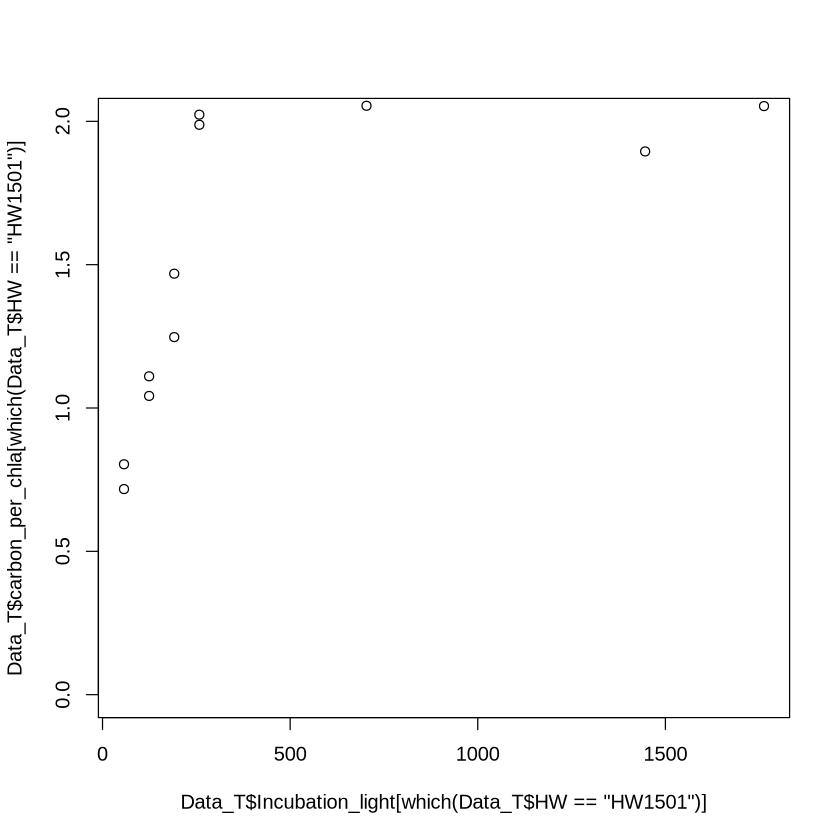

In [3]:
# 1. process raw data
## 1.1 process PI data

### refer to manual, pdf file: "Primary production calculation manual_V1.pdf"
### Version 1 to be updated into version 2

InputData_DPM = read.csv(file=paste(wd_path,"/rawdata/","DPM.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
InputData_DPM$HW <- trimws(InputData_DPM$HW)
InputData_DPM$HW <- sub(" ", "", InputData_DPM$HW, fixed = TRUE) # remove white space in between

Data_DPM = InputData_DPM[,c("HW","sample","DPM1")]
names(Data_DPM) = c("HW","sample","DPM_sample")
Data_DPM$DPM_sample = Data_DPM$DPM_sample%>%as.character()%>%as.numeric()

InputData_TTDPMC = read.csv(file=paste(wd_path,"/rawdata/","RUW.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
InputData_TTDPMC$HT <- trimws(InputData_TTDPMC$HT)
InputData_TTDPMC$HT <- sub(" ", "", InputData_TTDPMC$HT, fixed = TRUE) # remove white space in between

# Data_TTDPMC = InputData_TTDPMC[,c("HT","Sampling.Date","Sampling.Time","Chla_ug_per_l","DPM.1000","Temp..rel..DIC..mg.l.1.","Jetty.insitu_T","incubation_T","inc..duur..h.")]
Data_TTDPMC = InputData_TTDPMC[,c("HT","Sampling_Date","Sampling_Time","SPMCHLA_PLUS_µg_per_l","SDD","DPM_added_C","Temp_rel_DIC","Jetty_insitu_T","incubation_T","inc_duur","Licht_1","Licht_4","Licht_5","Licht_9","Licht_10")]
names(Data_TTDPMC) = c("HW","Date","Time","Chla_ug_per_l","Secchi_D","DPM_added","DIC","T_insitu","T_incubation","Incubation_duration_h","Licht_1","Licht_4","Licht_5","Licht_9","Licht_10")
Data_TTDPMC$T_insitu <- Data_TTDPMC$T_insitu%>%as.character()%>%as.numeric()
Data_TTDPMC$DIC = ((Data_TTDPMC$T_insitu^2)*0.0058)+(Data_TTDPMC$T_insitu*(-0.3169))+28.601
Data_TTDPMC$Date <- Data_TTDPMC$Date%>%dmy

InputData_DPMD = Data_DPM[which(Data_DPM$sample%in%c("DA","DB")),]
Data_DPM_noD = Data_DPM[-which(Data_DPM$sample%in%c("DA","DB","CAS","C","C1","C2","C3")),]

InputData_DPMD$DPM_sample <- InputData_DPMD$DPM_sample%>%as.character()%>%as.numeric()

Data_DPMD = InputData_DPMD %>% group_by(HW) %>% summarise(DPM_dark = mean(DPM_sample, na.rm=TRUE))

Data_TTDPM_C_D = merge(Data_TTDPMC,Data_DPMD,by="HW",all=TRUE)

#to calculate C fixation rate data from both df are needed, but these are of unequal length (480 en 24 resp).
#first merge dfs into one

Data_T <- merge(Data_TTDPM_C_D, Data_DPM_noD, by="HW",all = T)
Data_T$T_incubation <- Data_T$T_incubation%>%as.character()%>%as.numeric()
Data_T$T_insitu <- Data_T$T_insitu%>%as.character()%>%as.numeric()
Data_T$DPM_added <- Data_T$DPM_added%>%as.character()%>%as.numeric()
# Data_T$Incubation_duration_h <- Data_T$Incubation_duration_h%>%hms 

Data_T$Temp_factor = (exp(0.0693*(Data_T$T_insitu-Data_T$T_incubation)))
#calculate C fixation rate (mg C L-1 h-1) by
#DPM sample-DPM dark x 1.05 discrimination factor 14C/13C x [DIC] x temperature correction factor/DPM controle x duration of inc
Data_T$carbon <- ((Data_T$DPM_sample-Data_T$DPM_dark) * 1.05 *(Data_T$DIC) * Data_T$Temp_factor) / ((Data_T$DPM_added) * (Data_T$Incubation_duration_h)) # unit: mgC L-1 h-1
range(Data_T$carbon,na.rm = T) # unit: mgC L-1 h-1

Data_T$carbon_per_chla <- Data_T$carbon/(Data_T$Chla_ug_per_l*1e-3) # unit: mg C (mg Chla)-1 h-1
Data_T <- Data_T[!is.na(Data_T$sample),]

# now add a column with the light received per sample in the incubator to 'Data'

Data_Light = Data_T[,c("HW","Date","Time","Licht_1","Licht_4","Licht_5","Licht_9","Licht_10")]
names(Data_Light)[1:3] = c("HW","Date","Time")
#Data_Light <- na.omit(Data_Light)

library(zoo)
Data_Light <- Data_Light %>%
  mutate(across(starts_with("Licht"), as.numeric))

Data_Light <- Data_Light %>%
  mutate(across(starts_with("Licht"), ~replace(., .==0, NA)))

Light_data_interpolated <- Data_Light %>%
  mutate(across(starts_with("Licht"), ~ na.approx(., na.rm = FALSE)))

Light_data_filled <- Light_data_interpolated %>%
  mutate(across(starts_with("Licht"), ~ na.locf(., fromLast = TRUE, na.rm = FALSE))) %>%
  mutate(across(starts_with("Licht"), ~ na.locf(., na.rm = FALSE)))

Light_data_filled$Licht_2 = Light_data_filled$Licht_1 + (Light_data_filled$Licht_4-Light_data_filled$Licht_1)/3
Light_data_filled$Licht_3 = Light_data_filled$Licht_1 + 2*(Light_data_filled$Licht_4-Light_data_filled$Licht_1)/3
Light_data_filled$Licht_6 = Light_data_filled$Licht_5 + (Light_data_filled$Licht_9-Light_data_filled$Licht_5)/4
Light_data_filled$Licht_7 = Light_data_filled$Licht_5 + 2*(Light_data_filled$Licht_9-Light_data_filled$Licht_5)/4
Light_data_filled$Licht_8 = Light_data_filled$Licht_5 + 3*(Light_data_filled$Licht_9-Light_data_filled$Licht_5)/4

Data_T$Incubation_light <- NA
for(i in 1:nrow(Data_T)){
  light_col <- paste0("Licht_", as.numeric(gsub("[A-B]", "", Data_T$sample[i])))
  Data_T$Incubation_light[i] = Light_data_filled[i,light_col]  
}

Data_T<- Data_T[,-which(names(Data_T)%in%c("Licht_1","Licht_4","Licht_5","Licht_9","Licht_10"))]
#-------------------------------------------------------------------------------------------------------------
# Save finished df to dir_data
# Data file can be used as input in PE_curve_fit
# ------------------------------------------------------------------------------------------------------------



PI_input_2013_2023 = Data_T[,c("HW", "Incubation_light", "carbon", "carbon_per_chla")]
PI_2012 = read.csv(paste(rawdata_dir,"PI_2012.csv", sep="")) # Data from Jacobs et al., (2020)
names(PI_2012) = names(PI_input_2013_2023)
PI_input = rbind(PI_2012, PI_input_2013_2023)

PI_input$carbon_per_chla[which(PI_input$carbon_per_chla<0)]<- NA

plot(Data_T$Incubation_light[which(Data_T$HW=="HW1501")],
     Data_T$carbon_per_chla[which(Data_T$HW=="HW1501")],ylim=c(0,2))

# write.csv(PI_input, file = paste(wd_path,"processed_data/","PI_Input.csv",sep=""),row.names = F)

,SampleID,Timestamp..UTC.,T,S,SecchiDepth,TN,TP,PO4,NO3,NO2,NH4,DON,DOP,Si,DIC,TSM,Chl
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,HW7401,1974-02-07 07:15:00,5.000,29.960,0.300,NaN,NaN,2.800,52.200,2.800,8.046,NaN,NaN,18.414,27.640,NaN,4.486
3,HW7402,1974-02-14 11:08:00,6.000,29.420,0.600,NaN,NaN,3.000,56.500,4.500,6.033,NaN,NaN,19.611,NaN,NaN,1.298
4,HW7403,1974-02-20 05:58:00,5.200,27.280,0.500,NaN,NaN,2.900,65.800,4.200,17.708,NaN,NaN,18.514,28.540,NaN,2.937
5,HW7404,1974-02-27 09:40:00,4.700,25.520,0.180,NaN,NaN,2.600,93.700,2.300,13.582,NaN,NaN,32.072,26.920,NaN,7.167
6,HW7405,1974-03-07 06:10:00,4.600,28.190,0.850,NaN,NaN,2.300,68.400,1.600,10.462,NaN,NaN,20.907,25.950,11.620,2.255
7,HW7406,1974-03-13 10:05:00,4.300,29.560,1.200,NaN,NaN,2.200,54.500,1.500,7.140,NaN,NaN,16.420,25.760,11.750,2.163


'data.frame':	2122 obs. of  17 variables:
 $ SampleID       : chr  "HW7401" "HW7402" "HW7403" "HW7404" ...
 $ Timestamp..UTC.: chr  "1974-02-07 07:15:00" "1974-02-14 11:08:00" "1974-02-20 05:58:00" "1974-02-27 09:40:00" ...
 $ T              : chr  "     5.000" "     6.000" "     5.200" "     4.700" ...
 $ S              : chr  "    29.960" "    29.420" "    27.280" "    25.520" ...
 $ SecchiDepth    : chr  "     0.300" "     0.600" "     0.500" "     0.180" ...
 $ TN             : chr  "       NaN" "       NaN" "       NaN" "       NaN" ...
 $ TP             : chr  "       NaN" "       NaN" "       NaN" "       NaN" ...
 $ PO4            : chr  "     2.800" "     3.000" "     2.900" "     2.600" ...
 $ NO3            : chr  "    52.200" "    56.500" "    65.800" "    93.700" ...
 $ NO2            : chr  "     2.800" "     4.500" "     4.200" "     2.300" ...
 $ NH4            : chr  "     8.046" "     6.033" "    17.708" "    13.582" ...
 $ DON            : chr  "       NaN" "       N

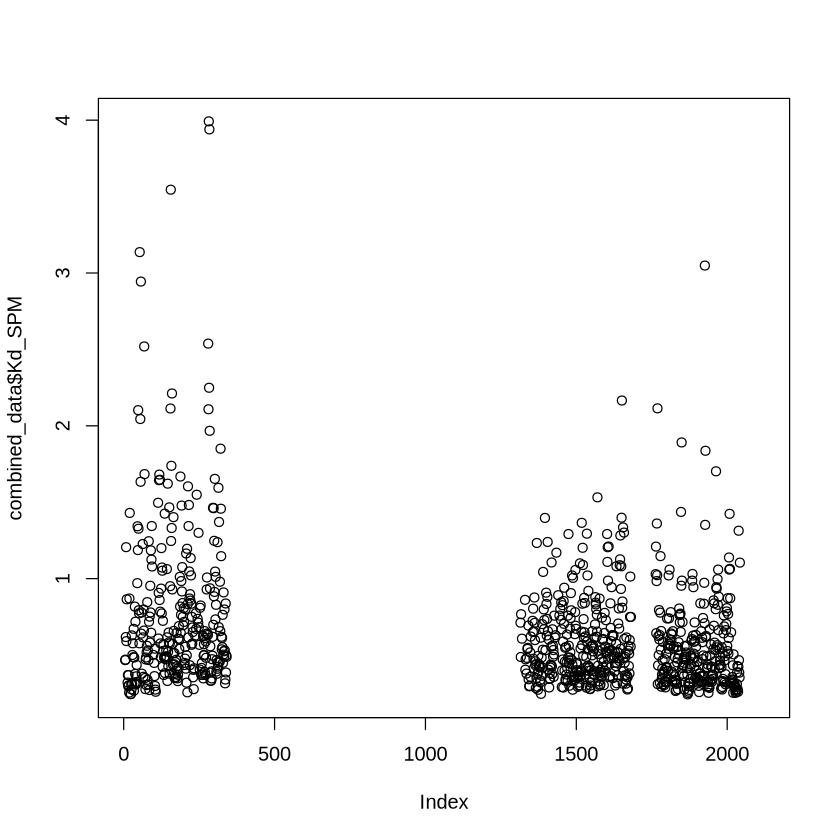

In [9]:
## 1.2 Process Jetty HW series

library(ggplot2)   # Plotting
library(mgcv)      # Generalized Additive Models (GAM)
library(dplyr)     # Data wrangling
library(lubridate) # Date handling

# Set the path to your folder containing the CSV files
folder_path <- paste(rawdata_dir, "HWseries/", sep="") # Replace with your actual folder path

file_list <- list.files(path = folder_path, 
                       pattern = "HWseries_\\d{4}\\.csv$",
                       full.names = TRUE)

# Initialize an empty list to store the data frames
combined_data <- NULL

# Loop through each year and read the corresponding CSV file
for (file_path in file_list) {

  # Check if the file exists before trying to read it
  if (file.exists(file_path)) {
    # Read the CSV file, skipping the first 3 rows
    data <- read.csv(file_path, skip = 3, header = TRUE)
    
    end_col = which(names(data)=="Chl")
    # Add the data to our list
    combined_data <- rbind(combined_data, data[-1,1:end_col])
    units = data[1,]
  } else {
    warning(paste("File not found:", file_path))
  }
}

head(combined_data)

# View the structure of the combined data
str(combined_data)

names(combined_data)[2] <- "timestamp"
combined_data$timestamp[which(combined_data$SampleID%in%paste0("HW",c(1201:1240, 1301:1340, 1401:1440, 1501:1540, 1601:1640, 2301:2340, 1601:1640)))] <- dmy_hm(combined_data$timestamp[which(combined_data$SampleID%in%paste0("HW",c(1201:1240, 1301:1340, 1401:1440, 1501:1540, 1601:1640, 2301:2340, 1601:1640)))])%>%as.character
combined_data$timestamp <- ymd_hms(combined_data$timestamp)

cols_to_convert <- 3:ncol(combined_data)
combined_data[cols_to_convert] <- lapply(combined_data[cols_to_convert], function(x){
  # first remove any commas (common in numeric data)
  x_clean <- gsub(",", "", x)
  # Then convert to numeric
  as.numeric(x_clean)
})

str(combined_data)

# Jetty secci to Kd, pars see Jacobs et al. 2020
# 1.476/Secci.SSD + 0.3541
# max secchi depth between 2010-2017 (based on "PrimProd_cfPhillippart_etal_2007.xlsx"): 3.24
secci_par_c = 1.476
secci_par_d = 0.3541
max_secci = 3.24
combined_data$Kd_Secci <- secci_par_c/combined_data$SecchiDepth + secci_par_d

# <- ifelse(PI_input$Secchi_D%in%c(">3.0",">3"), (secci_par_c/max_secci + secci_par_d), 
#                          (secci_par_c/(PI_input$Secchi_D%>%as.character()%>%as.numeric()) + secci_par_d))


# Or based on SPM (Loebl et al., 2009) 
# Kd = 0.188 + 0.024*SPM 

combined_data$Kd_SPM <- combined_data$TSM*0.024 + 0.188
plot(combined_data$timestap,combined_data$Kd_SPM)
# write.csv(combined_data, file = paste(wd_path,"/processed_data/","Jetty_HWseries.csv",sep=""),row.names = F)

In [5]:
PP_cal_dir

[1] "/home/jovyan/Virtual Labs/Waddenzee proto DT/Git public/Jetty_PPts//PP_cal/"

  0:     12.083739: 0.000228183 0.0204658  100.000
  1:     6.2064820: 0.000311074 0.0839314  98.3454
  2:     4.9730862: 0.000379269 0.215099  50.0799
  3:     4.9204433: 0.000457399 0.180041  56.7040
  4:     4.9203177: 0.000456819 0.180530  56.9719
  5:     4.9203174: 0.000457187 0.180253  57.0069
  6:     4.9203174: 0.000457147 0.180274  57.0061
  7:     4.9203174: 0.000457154 0.180270  57.0065
  0:     67.132385: 0.000849596 -0.227642  33.6449
  1:     59.239806: 0.000848318 -0.222017  35.4474
  2:     46.502036: 0.000696366 -0.202550  41.7862
  3:     36.139452: 0.000406510 -0.0887235  35.9054
  4:     27.687339: 9.49200e-05 0.0827997  18.5811
  5:     26.815604: 7.24717e-05 0.0919111  20.9164
  6:     26.759336: 5.73363e-05 0.102836  19.9425
  7:     26.755198: 5.52615e-05 0.103455  20.1013
  8:     26.754878: 5.40111e-05 0.104422  19.9869
  9:     26.754851: 5.39389e-05 0.104381  20.0138
 10:     26.754848: 5.38248e-05 0.104479  19.9998
 11:     26.754848: 5.38297e-05 0.104465 

Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     59.371166: 1.84550e-05 0.0545359  26.5088
  1:     36.667418: 2.20371e-05 0.0609191  28.2189
  2:     24.921003: 3.06460e-05 0.0686596  25.3803
  3:     21.802157: 5.02128e-05 0.0511053  26.5641
  4:     20.551502: 7.54856e-05 0.0162431  33.7827
  5:     20.531333: 7.89072e-05 0.0119213  34.7877
  6:     20.531184: 7.92052e-05 0.0115565  34.8550
  7:     20.531183: 7.92310e-05 0.0115242  34.8610
  8:     20.531183: 7.92333e-05 0.0115214  34.8615
  9:     20.531183: 7.92335e-05 0.0115212  34.8615
  0:     57.634214: 0.000207217 -0.0833008  43.0879
  1:     23.924060: 0.000148695 -0.0722566  55.2695
  2:     15.392928: 7.99383e-05 -0.00960936  50.5793
  3:     15.162364: 8.34219e-05 -0.0127401  52.8083
  4:     15.162198: 8.33211e-05 -0.0124759  52.7480
  5:     15.162197: 8.33418e-05 -0.0125144  52.7614
  6:     15.162197: 8.33387e-05 -0.0125087  52.7595
  7:     15.162197: 8.33392e-05 -0.0125095  52.7598
  0:     77.216117: 4.89474e-05 0.0114080  44.2681
  1:     42.473300: 5.

Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     16.418381: 5.39046e-05 0.106597  77.4287
  1:     8.2296532: 6.95988e-05 0.152039  80.8537
  2:     7.1405047: 7.03063e-05 0.201047  64.9391
  3:     6.6120878: 2.54181e-05 0.286509  41.7362
  4:     6.3770856: -3.58813e-05 0.380082  22.9316
  5:     6.3757006: -3.71681e-05 0.384023  22.3443
  6:     6.3756952: -3.73590e-05 0.384368  22.2706
  7:     6.3756952: -3.73754e-05 0.384399  22.2631
  8:     6.3756952: -3.73772e-05 0.384402  22.2623
  0:     5.3940915: 0.000103524 0.189524  93.6270
  1:     1.9471746: 8.91743e-05 0.334709  90.4424
  2:     1.6988606: 4.11903e-05 0.461309  72.1547
  3:     1.6875857: 2.40097e-06 0.521910  63.1987
  4:     1.6873895: 5.38594e-07 0.522972  63.9082
  5:     1.6873861: -1.75899e-07 0.524037  63.7237
  6:     1.6873861: -2.17308e-07 0.524062  63.7345
  7:     1.6873861: -2.31046e-07 0.524082  63.7310
  8:     1.6873861: -2.25782e-07 0.524074  63.7326
  9:     1.6873861: -2.25696e-07 0.524074  63.7325
 10:     1.6873861: -2.25696e-07 0.52407

Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     86.209512: 0.000201046 -0.133536  54.5067
  1:     72.936861: 0.000202782 -0.130481  56.7172
  2:     65.259096: 0.000192358 -0.126584  60.8916
  3:     59.776336: 0.000169370 -0.116232  63.9113
  4:     53.299265: 0.000119070 -0.0645178  53.0894
  5:     49.932095: 6.46933e-05 -0.000823347  37.8190
  6:     49.634237: 6.25281e-05 -0.00247573  40.1912
  7:     49.612509: 5.88421e-05 0.00235750  39.0215
  8:     49.610498: 5.86397e-05 0.00220073  39.2179
  9:     49.610316: 5.82972e-05 0.00265928  39.1010
 10:     49.610299: 5.82872e-05 0.00263230  39.1224
 11:     49.610297: 5.82551e-05 0.00267640  39.1108
 12:     49.610297: 5.82550e-05 0.00267272  39.1131
 13:     49.610297: 5.82520e-05 0.00267699  39.1119
 14:     49.610297: 5.82521e-05 0.00267646  39.1122
  0:     471.68067: 1.29838e-05 0.00847185  24.2981
  1:     213.91287: 1.44954e-05 0.0123962  29.6937
  2:     123.32157: 9.11599e-06 0.0221012  37.5307
  3:     112.55271: 6.82158e-07 0.0303676  40.7674
  4:     105.356

Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     71.382102: 3.84592e-05 -0.0253776  73.3480
  1:     66.269515: 4.15450e-05 -0.0216513  71.2455
  2:     57.442221: 4.64170e-05 -0.00352094  52.4281
  3:     56.893357: 2.99324e-05 0.0287010  39.6073
  4:     56.697412: 3.83403e-05 0.0137591  45.1549
  5:     56.682849: 3.66441e-05 0.0167770  44.1376
  6:     56.682355: 3.66986e-05 0.0167965  44.0221
  7:     56.682257: 3.66488e-05 0.0169433  43.9759
  8:     56.682255: 3.66764e-05 0.0168940  43.9938
  9:     56.682255: 3.66676e-05 0.0169104  43.9876
 10:     56.682255: 3.66709e-05 0.0169044  43.9898
 11:     56.682255: 3.66698e-05 0.0169065  43.9890
  0:     82.696950: 2.74393e-05 0.0297024  47.4306
  1:     56.447340: 2.94106e-05 0.0348896  54.2264
  2:     38.001736: 3.04724e-05 0.0454777  67.5453
  3:     34.473032: 8.46673e-06 0.0709927  73.5667
  4:     29.377406: -9.46626e-05 0.207222  40.2468
  5:     29.377406: -9.46626e-05 0.207222  40.2468


Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     6.3763249: 6.30903e-05 0.0368749  52.1017
  1:     3.0123634: 8.15794e-05 0.0346813  56.7029
  2:     2.9396444: 9.65233e-05 0.0202773  60.2009
  3:     2.9396189: 9.65762e-05 0.0202654  60.2265
  4:     2.9396189: 9.65755e-05 0.0202661  60.2264
  0:     19.400894: 0.000773410 -0.392636  106.740
  1:     15.280670: 0.000762476 -0.376128  116.330
  2:     13.655510: 0.000651799 -0.331707  123.132
  3:     9.0747579: 0.000122971 0.127739  41.8642
  4:     7.8883675: 5.81730e-05 0.165530  48.9347
  5:     7.7478886: 1.54338e-05 0.210552  43.4481
  6:     7.7340817: 6.74788e-06 0.215807  44.2278
  7:     7.7332847: 3.62774e-06 0.220026  43.3505
  8:     7.7332016: 3.95920e-06 0.219302  43.6227
  9:     7.7331890: 3.60460e-06 0.219808  43.4842
 10:     7.7331856: 3.74467e-06 0.219576  43.5552
 11:     7.7331848: 3.67125e-06 0.219694  43.5206
 12:     7.7331846: 3.69709e-06 0.219650  43.5339
 13:     7.7331846: 3.68998e-06 0.219662  43.5303
 14:     7.7331846: 3.69143e-06 0.219660  

Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     21.293521: 4.10687e-06 0.0808541  8.65256
  1:     9.8655871: 6.45463e-06 0.0953640  4.51722
  2:     9.5135255: 5.37169e-06 0.0999848  4.21601
  3:     9.5133267: 5.37119e-06 0.100057  4.21621
  4:     9.5133267: 5.37144e-06 0.100057  4.21625
  5:     9.5133267: 5.37144e-06 0.100057  4.21625
  0:     14.966243: 2.83183e-05 0.0908343  23.3377
  1:     5.8022329: 3.33503e-05 0.107868  24.5078
  2:     4.4788563: 2.06411e-05 0.138220  18.6127
  3:     4.3473677: 8.02620e-06 0.154750  16.0357
  4:     4.3467499: 7.55825e-06 0.155114  16.0425
  5:     4.3466047: 7.27623e-06 0.155498  16.0210
  6:     4.3466041: 7.24980e-06 0.155527  16.0178
  7:     4.3466041: 7.24745e-06 0.155529  16.0176
  8:     4.3466041: 7.24724e-06 0.155529  16.0175
  0:     12.370323: 1.96787e-05 0.0780371  10.0286
  1:     4.6583503: 2.07037e-05 0.0885662  10.5159
  2:     4.3859657: 1.48307e-05 0.0963851  9.66322
  3:     4.3640933: 1.15970e-05 0.0996879  9.21256
  4:     4.3638829: 1.14400e-05 0.0999154 

Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     308.56444: 5.49546e-06 0.0153960  25.6515
  1:     203.08017: 6.60062e-06 0.0194456  27.9760
  2:     158.49267: 6.86857e-06 0.0288940  22.7476
  3:     119.27640: -2.94850e-07 0.0491967  14.0802
  4:     119.27640: -2.94850e-07 0.0491967  14.0802


Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     36.121814: 2.18885e-05 0.0188532  37.3853
  1:     32.889316: 2.09301e-05 0.0238180  37.9353
  2:     29.257392: 1.12758e-05 0.0436932  30.8869
  3:     28.524895: 4.50892e-06 0.0577063  25.9122
  4:     28.513185: 5.33356e-06 0.0562237  26.3856
  5:     28.513099: 5.26479e-06 0.0563346  26.3679
  6:     28.513092: 5.26388e-06 0.0563472  26.3566
  7:     28.513092: 5.26379e-06 0.0563475  26.3565
  0:     4.7038847: 1.03442e-05 0.0677806  53.7025
  1:     3.8740361: 9.48030e-06 0.0770075  44.4297
  2:     3.7487524: 3.70820e-06 0.0898877  39.9126
  3:     3.7458233: 4.45553e-06 0.0881470  40.6349
  4:     3.7457806: 4.35894e-06 0.0883725  40.5498
  5:     3.7457798: 4.37126e-06 0.0883436  40.5609
  6:     3.7457798: 4.36967e-06 0.0883473  40.5595
  7:     3.7457798: 4.36988e-06 0.0883468  40.5597
  0:     11.059101: 2.39307e-05 0.0195287  42.8321
  1:     9.3317117: 2.25188e-05 0.0255386  41.5965
  2:     6.0264889: 3.84793e-06 0.0649032  26.6689
  3:     5.7188752: 7.18145e-06

Warning message in nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, :
“Convergence failure: false convergence (8)”


  0:     178.68737: 4.62407e-06 0.0228626  19.3711
  1:     63.379571: 5.28198e-06 0.0261653  23.5999
  2:     38.739763: 2.44236e-06 0.0351193  24.1068
  3:     28.284259: -6.01298e-06 0.0528224  18.4119
  4:     26.599749: -1.14826e-05 0.0634919  15.5114
  5:     26.543510: -1.09877e-05 0.0621074  16.2256
  6:     26.541560: -1.11430e-05 0.0624823  16.0830
  7:     26.541460: -1.11124e-05 0.0624042  16.1156
  8:     26.541455: -1.11196e-05 0.0624221  16.1083
  9:     26.541455: -1.11180e-05 0.0624181  16.1099
 10:     26.541455: -1.11184e-05 0.0624190  16.1096
 11:     26.541455: -1.11183e-05 0.0624188  16.1096
  0:     18.788678: 0.000105160 -0.0776873  94.6410
  1:     16.172559: 9.77391e-05 -0.0681614  99.2442
  2:     9.2712055: 4.57531e-05 0.0116642  76.0586
  3:     9.2711399: 4.57599e-05 0.0117597  76.0770
  4:     9.2706596: 4.57760e-05 0.0117562  76.0570
  5:     9.2612533: 4.57025e-05 0.0119755  75.9978
  6:     9.2005556: 4.51819e-05 0.0131218  75.5824
  7:     8.6981003: 

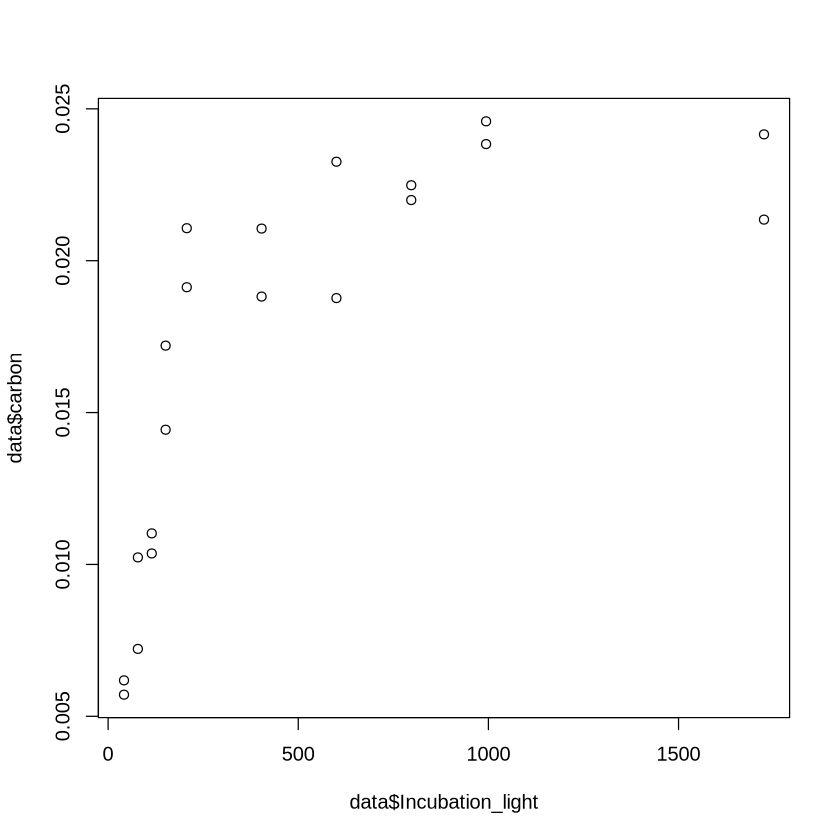

In [14]:
# 2. Fit PI curves
## Eilers & Peeters model 

PI_input = read.csv(paste(processed_data_dir,"PI_Input.csv", sep=""))

# adapted from EMS_Dollar 
sink(paste(PI_output_dir,"output.csv",sep=""))
cat("HWcode,a_fit,b_fit,c_fit,a_std_err,b_std_err,c_std_err,a_low,a_upp,b_low,b_upp,c_low,c_upp,residual_sum_of_squares,is_converged?,stop_message,number_of_iterations,degrees_of_freedom\n")
sink()

# Define the Michaelis-Menten model function
mm_model <- function(I, Pmax, K) {
  Pmax * I / (K + I)
}

# function to fit to data
fit_function <- function(x, a, b, c)
{
  return (x/(a*x^2 + b*x + c))
}

fit <- function(x,y,HWcode)
{
  # Make a best initial guess of parameters a, b, and c of fit_function
  # 1/c is equal to slope at x=0. Hence, c is estimate from the data at x=0 and the first x-value after that.
  x1 <- sort(x[x != 0])[1]
  y1 <- y[x != 0][order(x[x != 0])][1]
  c_guess <- x1/y1
  if (c_guess < 0) c_guess <- -c_guess
  # b = 1/Pm - 2*c/Im
  Pm <- max(y)
  Im <- x[which(y == Pm)][1]
  b_guess <- (1/Pm) - (c_guess*2/Im)
  a_guess <- c_guess/(Im^2)
  
  
  
  # Michaelis-Menten model intial fitting for outlier removal
  # Pmax_guess = max(y, na.rm = T)
  # K_guess = median(x, na.rm = T)
  # model3 <- NULL
  # model3 <- nls(y ~ mm_model(x, Pmax,K), start = list(Pmax = Pmax_guess, K=K_guess))
  # residuals <- abs(resid(model3))
  # threshold <- 2.5 * sd(residuals)
  # outliers <- residuals > threshold
  
  # # # Iterative outlier removal
  # model0 <- NULL
  # model0 <- nls(y ~ fit_function(x, a, b, c), start = list(a = a_guess, b = b_guess, c = c_guess),
  #                 trace = TRUE, control = list(warnOnly = TRUE))
  # residuals <- abs(resid(model0))
  # threshold <- 2 * sd(residuals)
  # outliers <- residuals > threshold
  
  # x_corr <- x[!outliers]
  # y_corr <- y[!outliers]
  x_corr <- x
  y_corr <- y
  
  model <- NULL
  model <- nls(y_corr ~ fit_function(x_corr, a, b, c), start = list(a = a_guess, b = b_guess, c = c_guess),
               trace = TRUE, control = list(warnOnly = TRUE),algorithm = "port")
  #
  
  # model <- NULL
  # model <- nls(y ~ fit_function(x, a, b, c), start = list(a = a_guess, b = b_guess, c = c_guess),
  #              trace = TRUE, control = list(warnOnly = TRUE))
  # 
  
  pars <- summary(model)$parameters[1:3, 1]
  pars_unc <- summary(model)$parameters[1:3, 2]
  
  filename <- HWcode
  
  sink(paste(PI_output_dir,"output.csv",sep=""), append = T)
  cat(HWcode)
  cat(",")
  cat(pars, sep =",")
  cat(",")
  cat(pars_unc, sep =",")
  sink()
  
  # x2 <- seq(0, 1800, len = 50)
  x2 <- seq(0, max(x), len = 50)
  myenv <- new.env()
  assign("a1", pars[1], envir = myenv)
  assign("b1", pars[2], envir = myenv)
  assign("c1", pars[3], envir = myenv)
  assign("x1", x2, envir = myenv)
  ff <- numericDeriv(quote(fit_function(x1, a1, b1, c1)), c("a1", "b1", "c1"), myenv)
  se.fit <- NULL
  se.fit <- sqrt(apply(attr(ff, "gradient"), 1, function(x) sum(vcov(model)*outer(x, x))))
  sumofsquares <- sum(summary(model)$residuals^2)
  degreesoffreedom <- summary(model)$df[2]
  # change confidence below for different confidence bands
  confidence <- 0.95
  t_values <- -qt((1-confidence)/2, degreesoffreedom)
  t_values <- c(-t_values, 0, t_values)
  
  sink(paste(PI_output_dir,"output.csv",sep=""), append = T)
  for (i in 1:3)
  {
    cat(",")
    cat(pars[i] + t_values[-2]*pars_unc[i], sep = ",")
  }
  cat(",")
  cat(sum(summary(model)$residuals^2))
  cat(",")
  cat(model$convInfo$isConv)
  cat(",")
  cat(model$convInfo$stopMessage)
  cat(",")
  cat(summary(model)$convInfo$finIter)
  cat(",")
  cat(degreesoffreedom)
  cat("\n")
  sink()
  
  pred <- NULL
  pred <- predict(model, list(x_corr = x2)) + outer(se.fit, t_values)
  
  png(paste(PI_output_dir, filename, ".png",sep=""))
  matplot(x2, pred, type="l", col=c(2,1,2), lty=c(2,1,2), 
          xlab = "PAR uE/m2/s", ylab = "Production mgC/mg Chla/h", 
          ylim=range(c(y, pred)), main=filename)
  points(x, y,col="darkred",pch=19)
  points(x_corr, y_corr,col="darkgreen",pch=19)
  
  dev.off()
  summary(model)
  
  #  print(paste("initial slope:", 1/pars[3]))
  slope_std_err <- sqrt((pars_unc[3]/pars[3])^2)/pars[3]
  #  print(paste("std err:", slope_std_err))
  slope_conf <- (1/pars[3]) + t_values*slope_std_err
  #  print(paste("95% lower and upper conf limit:", slope_conf[1], slope_conf[3]))
  
  c_a_ratio = pars[3]/pars[1]
  ifelse(c_a_ratio > 0, max_ETR_at <- sqrt(c_a_ratio), max_ETR_at<-NA)
  
  myenv <- new.env()
  assign("a1", pars[1], envir = myenv)
  assign("b1", pars[2], envir = myenv)
  assign("c1", pars[3], envir = myenv)
  assign("x1", max_ETR_at, envir = myenv)
  # ff <- NULL
  # ff <- numericDeriv(quote(fit_function(x1, a1, b1, c1)), c("a1", "b1", "c1"), myenv)
  # se.fit <- NULL
  # se.fit <- sqrt(apply(attr(ff, "gradient"), 1, function(x) sum(vcov(model)*outer(x, x))))
  # #  print(paste("ETRmax:", 1/(pars[2]+2*sqrt(pars[1]*pars[3]))))
  # #  print(paste("std err:", se.fit[1]))
  # max_conf <- predict(model, list(x = max_ETR_at)) + outer(se.fit, t_values)
  #  print(paste("95% lower and upper conf limit:", max_conf[1], max_conf[3]))
  sink(paste(PI_output_dir, filename, ".csv", sep=""))
  cat("x_fit,low_fit,med_fit,upp_fit,measured_x,measured_y,")
  cat(filename)
  cat("\n")
  temp <- cbind(x2, pred, c(x, rep(NA, length(x2) - length(x))), c(y, rep(NA, length(x2) - length(x))))
  for (i in 1:nrow(temp))
  {
    cat(temp[i,], sep = ",")
    cat("\n")
  }
  sink()
  
  return(list(HWcode,pars=pars))
}

# load processed incubation data and fit PI curve
# load processed incubation data and fit PI curve
remove_outliers <- function(x, y) {
  Q1 <- quantile(y, 0.25,na.rm = T)
  Q3 <- quantile(y, 0.75,na.rm = T)
  IQR <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR
  upper_bound <- Q3 + 1.5 * IQR
  non_outliers <- y >= lower_bound & y <= upper_bound
  list(x = x[non_outliers], y = y[non_outliers])
}

# PI_input <- na.omit(PI_input[,c("HW","Date","Time","datum","Incubation_light","carbon_per_chla","carbon")])
PI_input$HW <- as.factor(PI_input$HW)

for (HWcode in levels(PI_input$HW)) {
  data = PI_input[which(PI_input$HW==HWcode),]
  
  x = data$Incubation_light
  y = data$carbon_per_chla
  
  if(any(is.na(y))==F){
  # Remove outliers
  cleaned_data <- remove_outliers(x, y)
  x_clean <- cleaned_data$x
  y_clean <- cleaned_data$y
  
  fit(x_clean, y_clean,HWcode)}
}

# check HW2006 over high PP
plot(data$Incubation_light, data$carbon)

PI_output <- read.csv(paste(PI_output_dir,"output.csv", sep=""))

# remove problematic PI curves, determined based on the comments in the lab notebook , in combination with visual inspection of PI curves, and how outliers are determined in Jacobs et al., 2020
# problem_PI_samples <- c("HW1629","HW1701","HW1708","HW1724")
problem_PI_samples <- c("HW1209","HW1210","HW1212", "HW1318", "HW1414", "HW1416", "HW1417","HW1724", "HW1728", "HW1911", "HW1913", "HW1938", "HW2020", "HW2024", "HW2031", "HW2103", "HW2121", "HW2217", "HW2231", "HW2233")

# HW1209 has a extremly high optimum light of 16000
# "HW1228" (30 Pmax); "HW1312" (30); "HW1327" keep increasing;
# PI_output$I_opt = sqrt(PI_output$c_fit/PI_output$a_fit)

PI_output_v2 <- PI_output[-which(PI_output$HWcode%in%problem_PI_samples),]

Jetty_df = read.csv(file=paste(wd_path,"/processed_data/","Jetty_HWseries.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
Jetty_df$timestamp <- Jetty_df$timestamp%>%ymd_hms()

PI_output_v2$datum <- NA
for (i in 1:nrow(PI_output_v2)) {
  PI_output_v2$datum[i] = Jetty_df$timestamp[which(Jetty_df$SampleID==PI_output_v2$HWcode[i])]%>%as.character()
}

PI_output_v2$datum <- ymd_hms(PI_output_v2$datum)
# write.csv(PI_output_v2,file = paste(PI_output_dir,"output_v2.csv",sep=""),row.names = F)


  0:     7.0705327: 0.0100000  2.37000
  1:     5.5218887: 0.0140033  1.62289
  2:     5.2464265: 0.0173933  1.78066
  3:     5.2463528: 0.0174589  1.78317
  4:     5.2463528: 0.0174565  1.78320
  5:     5.2463528: 0.0174566  1.78320
  0:     27.477923: 0.0297222  6.39500
  1:     24.778135: 0.0357602  5.69228
  2:     24.712541: 0.0381518  5.69828
  3:     24.707647: 0.0373722  5.72485
  4:     24.706716: 0.0377153  5.71511
  5:     24.706558: 0.0375736  5.71942
  6:     24.706530: 0.0376336  5.71765
  7:     24.706525: 0.0376085  5.71840
  8:     24.706524: 0.0376190  5.71809
  9:     24.706524: 0.0376146  5.71822
 10:     24.706524: 0.0376165  5.71816
 11:     24.706524: 0.0376157  5.71819
 12:     24.706524: 0.0376160  5.71818
  0:     7.6306825: 0.0316667  5.33000
  1:     7.5317419: 0.0294361  5.29194
  2:     7.5303277: 0.0297446  5.28472
  3:     7.5303164: 0.0296744  5.28596
  4:     7.5302938: 0.0297095  5.28615
  5:     7.5302935: 0.0297049  5.28631
  6:     7.5302935: 0.029

Warning message in nls(y_corr ~ fit_function(x_corr, alpha, P_max), start = list(alpha = alpha_guess, :
“Convergence failure: false convergence (8)”


  0:     42.161562: 0.0346321  11.8773
  1:     34.058566: 0.0288890  11.5690
  2:     31.675110: 0.0244665  11.7304
  3:     31.442677: 0.0231246  11.8819
  4:     31.418386: 0.0228616  11.9307
  5:     31.377030: 0.0230451  11.9809
  6:     31.364931: 0.0229691  12.0392
  7:     31.364066: 0.0229096  12.0488
  8:     31.363915: 0.0228848  12.0528
  9:     31.363888: 0.0228744  12.0545
 10:     31.363884: 0.0228700  12.0552
 11:     31.363883: 0.0228682  12.0555
 12:     31.363883: 0.0228674  12.0556
 13:     31.363883: 0.0228671  12.0556
 14:     31.363883: 0.0228670  12.0556
  0:     147.47203: 0.0482313  17.0917
  1:     113.71617: 0.0451165  19.2383
  2:     111.19351: 0.0440381  20.0531
  3:     111.18531: 0.0443112  20.0408
  4:     111.18526: 0.0442920  20.0433
  5:     111.18526: 0.0442937  20.0431
  6:     111.18526: 0.0442935  20.0431
  0:     7.1825821: 0.0128402  4.28685
  1:     6.7996369: 0.0104902  4.36541
  2:     6.7932650: 0.0105130  4.40220
  3:     6.7932566: 0.010

Warning message in nls(y_corr ~ fit_function(x_corr, alpha, P_max), start = list(alpha = alpha_guess, :
“Convergence failure: false convergence (8)”


  0:     7.7741929: 0.0270380  7.61576
  1:     7.2597637: 0.0236639  7.68587
  2:     7.2449924: 0.0241486  7.67620
  3:     7.2449065: 0.0241144  7.67971
  4:     7.2449057: 0.0241179  7.67943
  5:     7.2449057: 0.0241175  7.67946
  6:     7.2449057: 0.0241176  7.67946
  0:     11.651580: 0.0680779  15.8733
  1:     10.651300: 0.0725204  16.0294
  2:     10.650670: 0.0726498  16.0316
  3:     10.650670: 0.0726512  16.0315
  4:     10.650670: 0.0726512  16.0315
  0:     58.704260: 0.0964491  16.2797
  1:     29.121876: 0.0592324  16.0613
  2:     27.966760: 0.0604807  16.5004
  3:     27.966418: 0.0604074  16.5050
  4:     27.966398: 0.0603893  16.5061
  5:     27.966396: 0.0603849  16.5064
  6:     27.966396: 0.0603838  16.5064
  7:     27.966396: 0.0603835  16.5064
  8:     27.966396: 0.0603834  16.5065
  0:     30.903277: 0.0949618  24.4159
  1:     30.768299: 0.0966263  24.4461
  2:     30.768126: 0.0965662  24.4504
  3:     30.768125: 0.0965698  24.4503
  4:     30.768125: 0.096

Warning message in nls(y_corr ~ fit_function(x_corr, alpha, P_max), start = list(alpha = alpha_guess, :
“Convergence failure: false convergence (8)”


  0:     35.100504: 0.0491048  9.01577
  1:     30.251663: 0.0380078  8.88000
  2:     30.229951: 0.0371558  8.89978
  3:     30.229418: 0.0372829  8.89419
  4:     30.229405: 0.0372640  8.89516
  5:     30.229405: 0.0372669  8.89502
  6:     30.229405: 0.0372664  8.89504
  7:     30.229405: 0.0372665  8.89503
  0:     40.141986: 0.0521150  8.78209
  1:     36.801345: 0.0433722  8.30494
  2:     36.797529: 0.0437376  8.31007
  3:     36.797529: 0.0437375  8.31015
  4:     36.797529: 0.0437375  8.31015
  0:     82.889072: 0.0424526  12.2538
  1:     78.746503: 0.0496489  12.2058
  2:     78.558988: 0.0518254  12.2379
  3:     78.555046: 0.0514795  12.2586
  4:     78.554839: 0.0515614  12.2546
  5:     78.554829: 0.0515431  12.2555
  6:     78.554828: 0.0515472  12.2553
  7:     78.554828: 0.0515463  12.2554
  8:     78.554828: 0.0515465  12.2554
  0:     68.266971: 0.0370393  12.5158
  1:     52.658543: 0.0286985  14.2972
  2:     50.895697: 0.0274261  15.1131
  3:     50.783053: 0.026

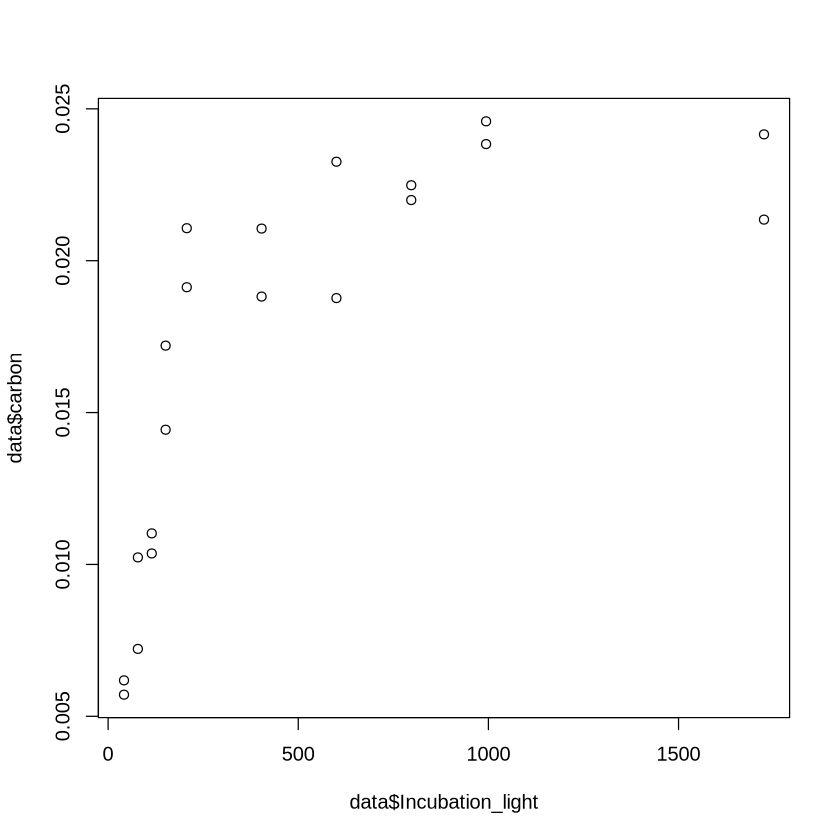

In [17]:

## Jassby & Platt model 
# derive the parameters a, b, c
PI_input = read.csv(paste(processed_data_dir,"PI_Input.csv", sep=""))
# remove problematic PI curves, determined based on the comments in the lab notebook , in combination with visual inspection of PI curves, and how outliers are determined in Jacobs et al., 2020
# problem_PI_samples <- c("HW1629","HW1701","HW1708","HW1724")
problem_PI_samples <- c("HW1209","HW1210","HW1212", "HW1318","HW1327", "HW1414", "HW1416", "HW1417", "HW1421", "HW1724", "HW1728","HW1835", "HW1911", "HW1913", "HW1938", "HW2020", "HW2024", "HW2031", "HW2103", "HW2121","HW2134", "HW2217","HW2221", "HW2231", "HW2233")

PI_input <- PI_input[-which(PI_input$HW%in%problem_PI_samples),]
PI_input$HW <- as.factor(PI_input$HW)

# adapted from EMS_Dollar 
sink(paste(PI_output_dir,"output_JP.csv",sep=""))
cat("HWcode,alpha,P_max,alpha_std_err,P_max_std_err,alpha_low,alpha_upp,P_max_low,P_max_upp,residual_sum_of_squares,is_converged?,stop_message,number_of_iterations,degrees_of_freedom\n")
sink()

# Define the Michaelis-Menten model function
mm_model <- function(I, Pmax, K) {
  Pmax * I / (K + I)
}

# function to fit to data
fit_function <- function(x, alpha, P_max)
{
  return (
    P_max*tanh((alpha*x)/P_max)
    )
}

fit <- function(x,y,HWcode)
{
  # Make a best initial guess of parameters a, b, and c of fit_function
  # 1/c is equal to slope at x=0. Hence, c is estimate from the data at x=0 and the first x-value after that.
  x1 <- sort(x[x != 0])[1]
  y1 <- y[x != 0][order(x[x != 0])][1]
  alpha_guess <- y1/x1
  P_max_guess <- quantile(y,0.75)
  
  x_corr <- x
  y_corr <- y
  
  model <- NULL
  model <- nls(y_corr ~ fit_function(x_corr, alpha, P_max), start = list(alpha = alpha_guess, P_max = P_max_guess),
               trace = TRUE, control = list(warnOnly = TRUE),algorithm = "port")
  #

  
  pars <- summary(model)$parameters[1:2, 1]
  pars_unc <- summary(model)$parameters[1:2, 2]
  
  filename <- paste0(HWcode,"_JP")
  
  sink(paste(PI_output_dir,"output_JP.csv",sep=""), append = T)
  cat(HWcode)
  cat(",")
  cat(pars, sep =",")
  cat(",")
  cat(pars_unc, sep =",")
  sink()
  
  # x2 <- seq(0, 1800, len = 50)
  x2 <- seq(0, max(x), len = 50)
  myenv <- new.env()
  assign("alpha", pars[1], envir = myenv)
  assign("P_max", pars[2], envir = myenv)
  assign("x1", x2, envir = myenv)
  ff <- numericDeriv(quote(fit_function(x1, alpha, P_max)), c("alpha", "P_max"), myenv)
  se.fit <- NULL
  se.fit <- sqrt(apply(attr(ff, "gradient"), 1, function(x) sum(vcov(model)*outer(x, x))))
  sumofsquares <- sum(summary(model)$residuals^2)
  degreesoffreedom <- summary(model)$df[2]
  # change confidence below for different confidence bands
  confidence <- 0.95
  t_values <- -qt((1-confidence)/2, degreesoffreedom)
  t_values <- c(-t_values, 0, t_values)
  
  sink(paste(PI_output_dir,"output_JP.csv",sep=""), append = T)
  for (i in 1:2)
  {
    cat(",")
    cat(pars[i] + t_values[-2]*pars_unc[i], sep = ",")
  }
  cat(",")
  cat(sum(summary(model)$residuals^2))
  cat(",")
  cat(model$convInfo$isConv)
  cat(",")
  cat(model$convInfo$stopMessage)
  cat(",")
  cat(summary(model)$convInfo$finIter)
  cat(",")
  cat(degreesoffreedom)
  cat("\n")
  sink()
  
  pred <- NULL
  pred <- predict(model, list(x_corr = x2)) + outer(se.fit, t_values)
  
  png(paste(PI_output_dir, filename, ".png",sep=""))
  matplot(x2, pred, type="l", col=c(2,1,2), lty=c(2,1,2), 
          xlab = "PAR uE/m2/s", ylab = "Production mgC/mg Chla/h", 
          ylim=range(c(y, pred)), main=filename)
  points(x, y,col="darkred",pch=19)
  points(x_corr, y_corr,col="darkgreen",pch=19)
  
  dev.off()
  summary(model)
  
  return(list(HWcode,pars=pars))
}

# load processed incubation data and fit PI curve
# load processed incubation data and fit PI curve
remove_outliers <- function(x, y) {
  Q1 <- quantile(y, 0.25,na.rm = T)
  Q3 <- quantile(y, 0.75,na.rm = T)
  IQR <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR
  upper_bound <- Q3 + 1.5 * IQR
  non_outliers <- y >= lower_bound & y <= upper_bound
  list(x = x[non_outliers], y = y[non_outliers])
}

# PI_input <- na.omit(PI_input[,c("HW","Date","Time","datum","Incubation_light","carbon_per_chla","carbon")])



for (HWcode in levels(PI_input$HW)) {
  data = PI_input[which(PI_input$HW==HWcode),]
  
  x = data$Incubation_light
  y = data$carbon_per_chla
  
  if(any(is.na(y))==F){
  # # Remove outliers
  cleaned_data <- remove_outliers(x, y)
  x_clean <- cleaned_data$x
  y_clean <- cleaned_data$y
  # 
  fit(x_clean, y_clean,HWcode)}
}

# check HW2006 over high PP
plot(data$Incubation_light, data$carbon)

PI_output <- read.csv(paste(PI_output_dir,"output_JP.csv", sep=""))

# HW1209 has a extremly high optimum light of 16000
# "HW1228" (30 Pmax); "HW1312" (30); "HW1327" keep increasing;
# PI_output$I_opt = sqrt(PI_output$c_fit/PI_output$a_fit)

PI_output_v2 <- PI_output

Jetty_df = read.csv(file=paste(wd_path,"/processed_data/","Jetty_HWseries.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
Jetty_df$timestamp <- Jetty_df$timestamp%>%ymd_hms()

PI_output_v2$datum <- NA
for (i in 1:nrow(PI_output_v2)) {
  PI_output_v2$datum[i] = Jetty_df$timestamp[which(Jetty_df$SampleID==PI_output_v2$HWcode[i])]%>%as.character()
}

PI_output_v2$datum <- ymd_hms(PI_output_v2$datum)
# write.csv(PI_output_v2,file = paste(PI_output_dir,"output_JP_v2.csv",sep=""),row.names = F)


Loading required package: pracma


Attaching package: ‘pracma’


The following object is masked from ‘package:mgcv’:

    magic




,a_fit,b_fit,c_fit
a_fit,1.0000000,-0.1920725,0.5380644
b_fit,-0.1920725,1.0000000,0.2878826
c_fit,0.5380644,0.2878826,1.0000000


 POSIXct[1:396], format: "2012-02-16 11:34:00" "2012-03-01 10:38:00" "2012-03-12 09:25:00" ...


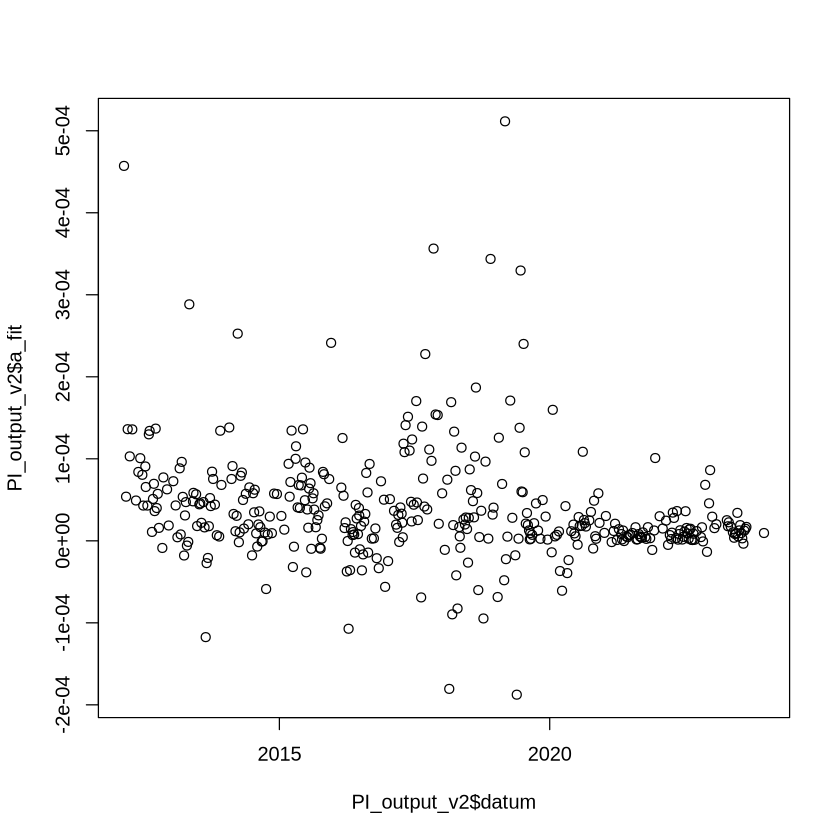

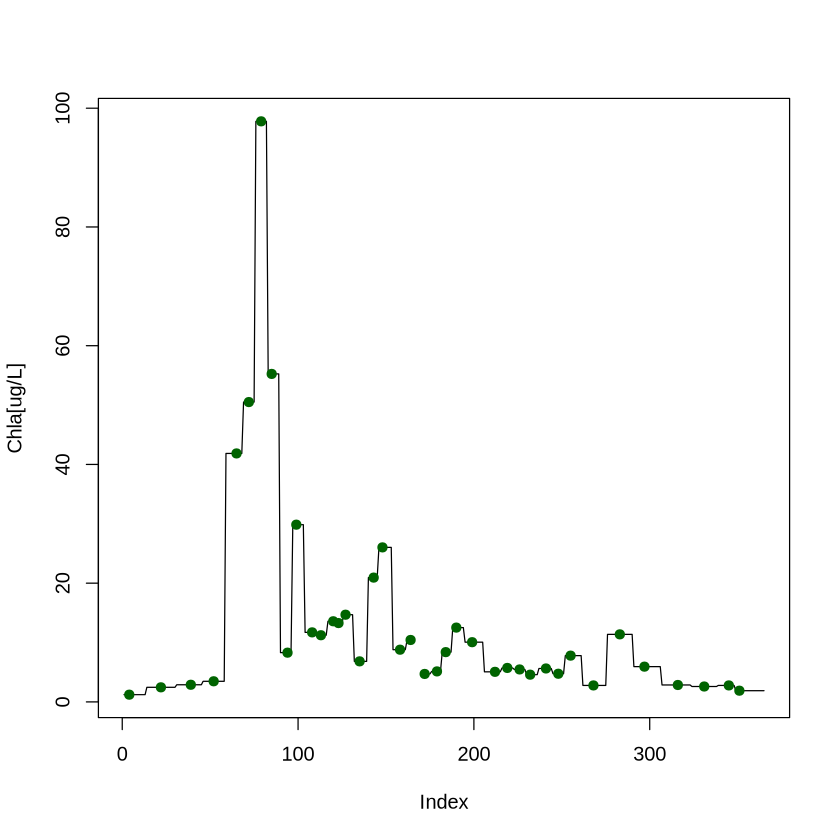

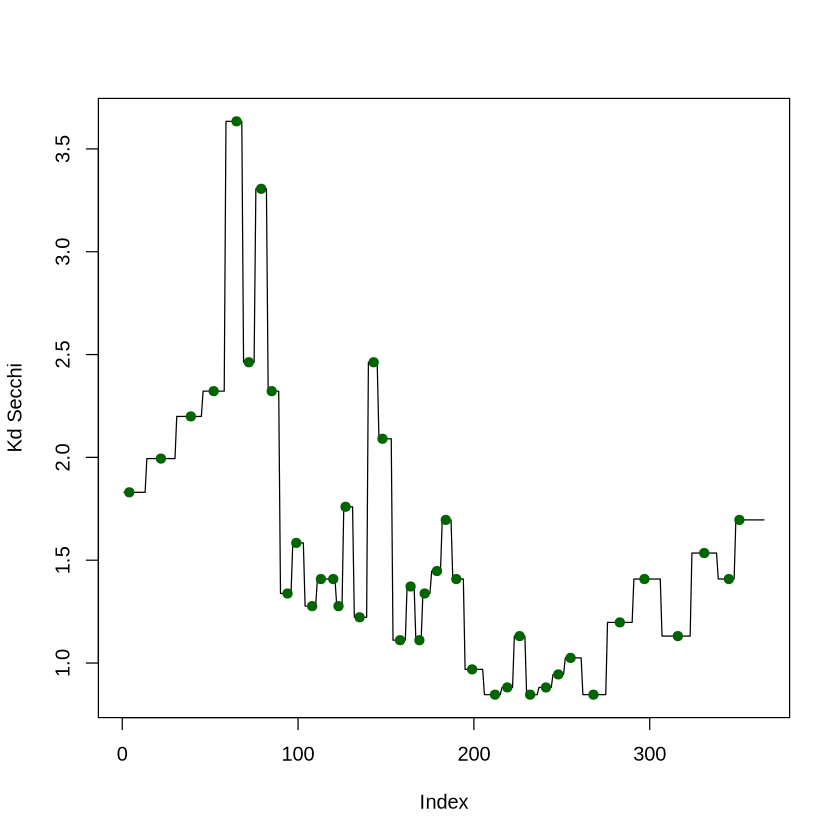

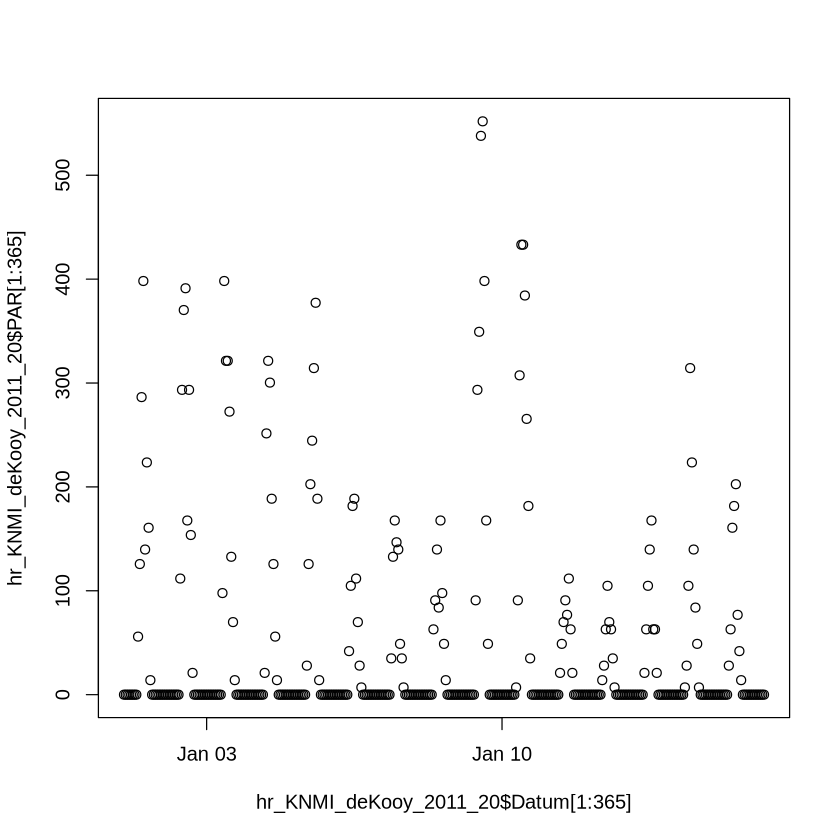

,Date,Day,Chl,Kd_Secci,a_fit,b_fit,c_fit,a_std_err,b_std_err,c_std_err,a_low,a_upp,b_low,b_upp,c_low,c_upp,residual_sum_of_squares
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012-01-02 00:00:00,1.000000,2.146,3.3061,0.0004571536,0.1802698,57.00648,0.0003885083,0.274367,38.94392,-0.0003664472,0.001280754,-0.4013622,0.7619019,-25.55095,139.5639,9.840635
2,2012-01-02 01:00:00,1.041667,2.146,3.3061,0.0004571536,0.1802698,57.00648,0.0003885083,0.274367,38.94392,-0.0003664472,0.001280754,-0.4013622,0.7619019,-25.55095,139.5639,9.840635
3,2012-01-02 02:00:00,1.083333,2.146,3.3061,0.0004571536,0.1802698,57.00648,0.0003885083,0.274367,38.94392,-0.0003664472,0.001280754,-0.4013622,0.7619019,-25.55095,139.5639,9.840635
4,2012-01-02 03:00:00,1.125000,2.146,3.3061,0.0004571536,0.1802698,57.00648,0.0003885083,0.274367,38.94392,-0.0003664472,0.001280754,-0.4013622,0.7619019,-25.55095,139.5639,9.840635
5,2012-01-02 04:00:00,1.166667,2.146,3.3061,0.0004571536,0.1802698,57.00648,0.0003885083,0.274367,38.94392,-0.0003664472,0.001280754,-0.4013622,0.7619019,-25.55095,139.5639,9.840635
6,2012-01-02 05:00:00,1.208333,2.146,3.3061,0.0004571536,0.1802698,57.00648,0.0003885083,0.274367,38.94392,-0.0003664472,0.001280754,-0.4013622,0.7619019,-25.55095,139.5639,9.840635


Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA function value encountered.”
Warning message in .gkadpt(f, a, b, tol = tol):
“Infinite or NA functi

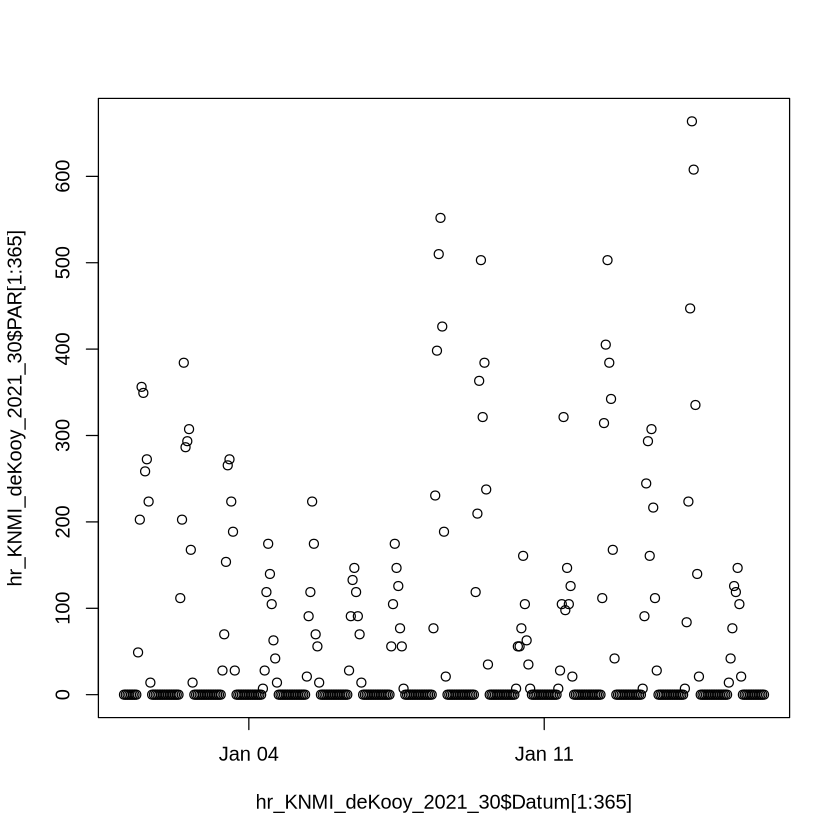

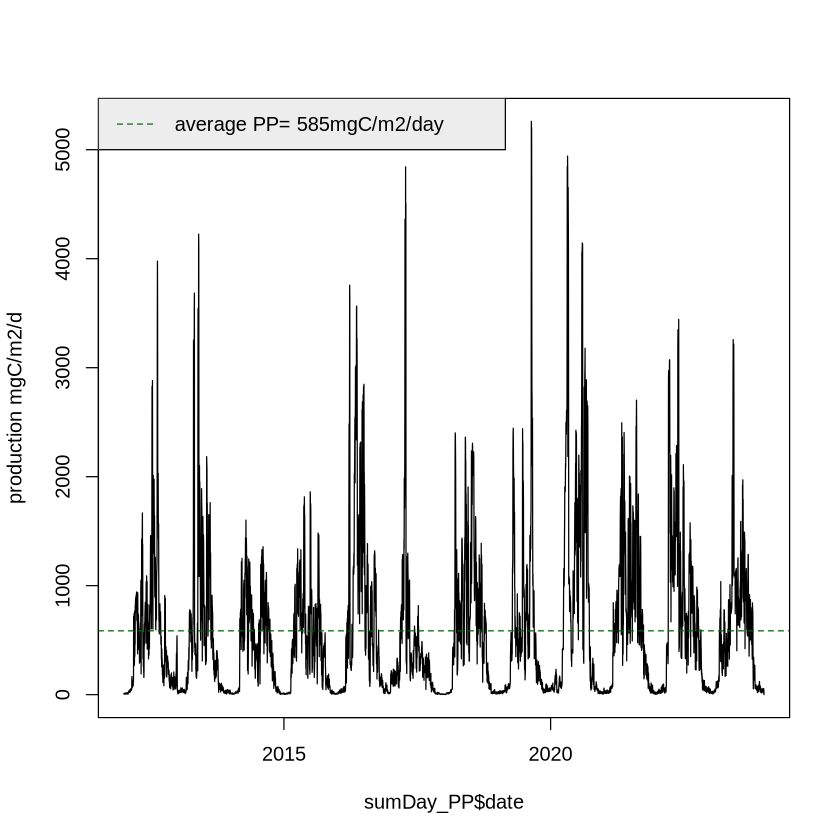

In [24]:
# 3. PP integration
## 3.1 EP PI model 2012-2023
require(pracma)

Jetty_df = read.csv(file=paste(wd_path,"/processed_data/","Jetty_HWseries.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
Jetty_df$timestamp <- Jetty_df$timestamp%>%ymd_hms()

PI_output_v2 <- read.csv(paste(PI_output_dir,"output_v2.csv", sep=""))

cor(PI_output_v2[,c("a_fit","b_fit","c_fit")]) # results showed high intercorrelation between a, b,c. not in line with Ems-Dollard data report, in which they stated that c is less corrected with a or b.

PI_output_v2$datum <- ymd_hms(PI_output_v2$datum)

str(PI_output_v2$datum)
plot(PI_output_v2$datum, PI_output_v2$a_fit)


cleaned_PI <- PI_output_v2%>%na.omit

# perform rectangular interpolation to derive daily values of Eilers-Peeters a, b, and c

daily_date <- seq.Date(from = ymd("2012-01-01"), to = ymd("2022-12-31"), by = "day")

days <- yday(daily_date)

# Function to perform rectangular interpolation for one year
days_in_year <- function(year) {
  start_date <- ymd(paste0(year, "-01-01"))
  end_date <- ymd(paste0(year, "-12-31"))
  return(as.integer(end_date - start_date + 1))
}

rectangular_interpolation <- function(year,days, values) {
  daily_values <- numeric(days_in_year(year))
  
  # Fill in the initial period with the first measurement
  daily_values[1:floor(days[1])] <- values[1]
  
  # Interpolate between measurements
  for (i in 1:(length(values) - 1)) {
    start_day <- floor(days[i])
    end_day <- floor(days[i + 1])
    mid_point <- floor((start_day + end_day) / 2)
    
    # Fill in the first half with the current measurement
    daily_values[start_day:mid_point] <- values[i]
    
    # Fill in the second half with the next measurement
    daily_values[(mid_point + 1):end_day] <- values[i + 1]
  }
  
  # Fill in the last period with the last measurement
  daily_values[floor(days[length(values)]):365] <- values[length(values)]
  
  return(daily_values)
}

# Apply the interpolation for each PI variable and each year
years <- cleaned_PI$datum%>%year()%>%unique
daily_PIdata <- data.frame()
for (year in years) {
  year_data <- cleaned_PI[cleaned_PI$datum%>%year == year, ]
  
  col_names <- c("a_fit","b_fit","c_fit","a_std_err","b_std_err","c_std_err","a_low","a_upp","b_low","b_upp","c_low","c_upp","residual_sum_of_squares")
  
  daily_values_list <- lapply(col_names, function(var) {
    rectangular_interpolation(year = year,year_data$datum%>%yday, year_data[[var]])
  })
  
  year_daily_data <- data.frame(
    Year = year,
    Day = 1:days_in_year(year),
    Date = paste(year,"-01-01")%>%ymd()+(1:days_in_year(year))
  )
  
  for (i in seq_along(daily_values_list)) {
    year_daily_data[[col_names[i]]] <- daily_values_list[[i]]
  }
  
  daily_PIdata <- rbind(daily_PIdata, year_daily_data)
}
# write.csv(daily_PIdata,file = paste(wd_path,"/processed_data/","daily_PIdata.csv",sep=""),row.names = F)


daily_df <- data.frame()

for (year in years) {
  year_data <- Jetty_df[Jetty_df$timestamp%>%year == year, ]
  
  col_names <- c("Chl","Kd_Secci")
  
  daily_values_list <- lapply(col_names, function(var) {
    rectangular_interpolation(year = year,year_data$timestamp%>%yday, year_data[[var]])
  })
  
  year_daily_data <- data.frame(
    Year = year,
    Day = 1:days_in_year(year),
    Date = paste(year,"-01-01")%>%ymd()+(1:days_in_year(year))
  )
  
  for (i in seq_along(daily_values_list)) {
    year_daily_data[[col_names[i]]] <- daily_values_list[[i]]
  }
  
  daily_df <- rbind(daily_df, year_daily_data)
}

plot(daily_df$Chl[which(daily_df$Year==2018)],type="l", ylab="Chla[ug/L]")
points(Jetty_df$timestamp[which(Jetty_df$timestamp%>%year==2018)]%>%yday,Jetty_df$Chl[which(Jetty_df$timestamp%>%year==2018)],pch=19,col="darkgreen")

plot(daily_df$Kd_Secci[which(daily_df$Year==2018)],type="l", ylab="Kd Secchi")
points(Jetty_df$timestamp[which(Jetty_df$timestamp%>%year==2018)]%>%yday,Jetty_df$Kd_Secci[which(Jetty_df$timestamp%>%year==2018)],pch=19,col="darkgreen")

hr_KNMI_filepath_2011_2020 <- paste(wd_path,"/rawdata/","uurgeg_235_2011-2020.txt",sep="")
hr_KNMI_filepath_2021_2030 <- paste(wd_path,"/rawdata/","uurgeg_235_2021-2030.txt",sep="")

hr_KNMI_deKooy_2011_20 <- read.table(hr_KNMI_filepath_2011_2020,header=TRUE, sep=",")
hr_KNMI_deKooy_2011_20$PAR = hr_KNMI_deKooy_2011_20$Q*1e4/3600*2.515 # Conversion from KNMI (W m-2) to PAR (uE m-2 s-1), reference Brinkman et al., 2015, EMS-Dollard data report
hr_KNMI_deKooy_2011_20$Datum <- paste(hr_KNMI_deKooy_2011_20$YYYYMMDD, hr_KNMI_deKooy_2011_20$HH,sep=" ")%>%ymd_h
plot(hr_KNMI_deKooy_2011_20$Datum[1:365], hr_KNMI_deKooy_2011_20$PAR[1:365])

###
hr_KNMI_deKooy_2021_30 <- read.table(hr_KNMI_filepath_2021_2030, header=TRUE, sep=",")
hr_KNMI_deKooy_2021_30$PAR = hr_KNMI_deKooy_2021_30$Q*1e4/3600*2.515 # Conversion from KNMI (W m-2) to PAR (uE m-2 s-1), reference Brinkman et al., 2015, EMS-Dollard data report
hr_KNMI_deKooy_2021_30$Datum <- paste(hr_KNMI_deKooy_2021_30$YYYYMMDD, hr_KNMI_deKooy_2021_30$HH,sep=" ")%>%ymd_h
plot(hr_KNMI_deKooy_2021_30$Datum[1:365], hr_KNMI_deKooy_2021_30$PAR[1:365])

hr_KNMI_deKooy <- rbind(hr_KNMI_deKooy_2011_20, hr_KNMI_deKooy_2021_30)

# load water height data from dtR by Karline
# Water heights are downloaded from a nearby station, OudeSchild (OUDSD, 4.850192, 53.03884).
# Check den helder water depth (program)
# load(paste(wd_path,"/processed_data/","WHeightJetty.rda",sep=""))

# WH_2015_17 <- subset(WHeightJetty,
#                      datetime>=as.POSIXct("2015-01-01") &
#                        datetime <= as.POSIXct("2017-12-31"))


# daily_HW <- WH_2015_17%>%group_by(datetime%>%date)%>%summarise(daily_height=mean(Height,na.rm = TRUE))

# names(daily_HW) <- c("datum","daily_height")

#### interpolate daily data to hourly data ####
# Create a data frame
daily_df <- merge(daily_df, daily_PIdata, by=c("Year","Day","Date"))

# Generate hourly timestamps
time_period <- paste(range(daily_df$Date),"00:00:00")%>%ymd_hms
hourly_dates <- seq.POSIXt(from = time_period[1], to = time_period[2], by = "hour")

# Interpolation function
interpolate_to_hourly <- function(daily_data, hourly_dates) {
  hourly_data <- data.frame(Date = hourly_dates)
  
  for (var in names(daily_data)[-1]) {
    # hourly_data[[var]] <- approx(x = as.numeric(daily_data$Date%>%as.POSIXct()), 
    #                              y = daily_data[[var]], 
    #                              xout = as.numeric(hourly_dates), 
    #                              method = "linear",rule=2)$y
    hourly_data[[var]] <- approx(x = as.numeric(daily_data$Date%>%as.POSIXct()), 
                                 y = daily_data[[var]], 
                                 xout = as.numeric(hourly_dates), 
                                 method = "linear",rule=2)$y
  }
  
  return(hourly_data)
}

# Interpolate data
hourly_data <- interpolate_to_hourly(daily_df, hourly_dates)
hourly_data$Date <- hourly_dates
# View the first few rows of the interpolated data
head(hourly_data)

# integration function to calculate PP based on light, Chla


# Define the primary production function as a function of depth


integrate_primary_production <- function(z) {
  #PAR :photosynthetically active radiation,μE m‐2 s‐1
  # Chla: mg Chla
  # a,b,c Eilers-Peeters PI curve, a, b, c parameters
  
  light_at_depth <- light_surface * exp(-k * z)*(1-0.07)# reflecting of solar radiatio nat the surface by 5-10%, ref Brinkman et al., 2015
  
  # Example primary production function (modify as needed)
  production <- (light_at_depth/(a*light_at_depth^2 + b*light_at_depth + c))*Chla # unit: PP (mg C m-2 h-1)  
  return(production)
}

# integrated_PP_daily = data.frame(datum=daily_PIdata$Date%>%ymd,PP=NA)
# depth_range = c(0, 3.3) # assuming 10 m constant depth, depth from Katja
# for (i in 1:nrow(integrated_PP_daily)) {
#   # Define the depth range for integration (e.g., from 0 to 100 meters)
#   
#   light_surface = hr_KNMI_deKooy$PAR[i]
#   a = daily_PIdata$a_fit[i]
#   b = daily_PIdata$b_fit[i]
#   c = daily_PIdata$c_fit[i]
#   k = daily_Kd$Kd_ave[i]
#   Chla = daily_Chla$Chla_ug_l[i] # unit conversion: 1 ug Chla/L = 1 mg/m3
#   water_depth = 4.6 #assuming fixed water depth = 4.6, ref. Jacobs et al., 2020
#   
#   integrated_PP_daily$PP[i] <-  integral(integrate_primary_production, 0, water_depth)
#   
# }

integrated_PP_hourly <- merge(hr_KNMI_deKooy[,c("Q","PAR","Datum","STN")], hourly_data[,c("Date","Chl","Kd_Secci","a_fit","b_fit","c_fit")],by.x="Datum", by.y="Date")
integrated_PP_hourly$PP <- NA
# integrated_PP_hourly = data.frame(datum=hourly_dates,PP=NA)
for (i in 1:nrow(integrated_PP_hourly)) {
  # Define the depth range for integration (e.g., from 0 to 100 meters)
  
  light_surface = integrated_PP_hourly$PAR[i]
  a = integrated_PP_hourly$a_fit[i]
  b = integrated_PP_hourly$b_fit[i]
  c = integrated_PP_hourly$c_fit[i]
  k = integrated_PP_hourly$Kd_Secci[i]
  Chla = integrated_PP_hourly$Chl[i] # unit conversion: 1 ug Chla/L = 1 mg/m3
  water_depth = 4.6 #assuming fixed water depth = 4.6, ref. Jacobs et al., 2020
  
  
  integrated_PP_hourly$PP[i] <-  integral(integrate_primary_production, 0, water_depth)
  
}

sumDay_PP <- integrated_PP_hourly%>%
  mutate(date=as.Date(Datum))%>%
  group_by(date)%>%
  summarize(daily_PP=sum(PP,na.rm=T))

plot(sumDay_PP$date,sumDay_PP$daily_PP,ylab="production mgC/m2/d",t="l")
abline(h=mean(sumDay_PP$daily_PP),lty=2,col="darkgreen")
legend("topleft",legend = paste("average PP= ", trunc(mean(sumDay_PP$daily_PP)), "mgC/m2/day", sep=""),lty=2,col = "darkgreen",bg="grey93")

# write.csv(sumDay_PP, file=paste(wd_path,"/PP_cal/","sumDay_PP.csv",sep=""))



Family: Gamma 
Link function: log 

Formula:
daily_PP ~ s(doy, bs = "tp", k = 10)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.68062    0.01395   407.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
        edf Ref.df    F p-value    
s(doy) 8.93  8.999 1174  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.405   Deviance explained = 67.6%
GCV = 0.6525  Scale est. = 0.85299   n = 4383

[1] 58277.5

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


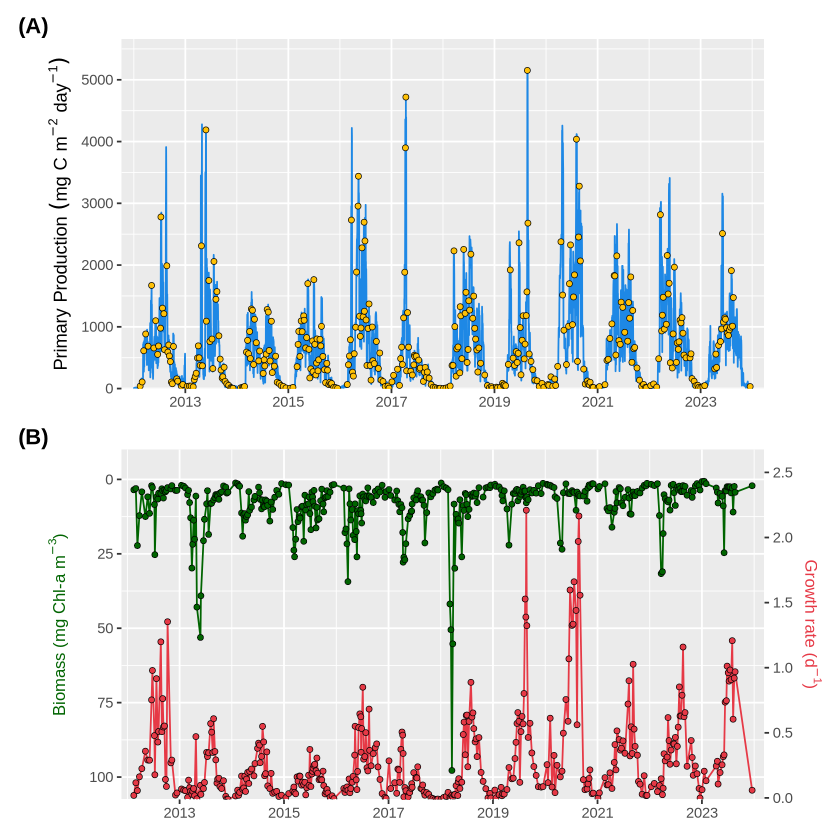

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `year_frac >= 2018`.
[1mCaused by error:[22m
[33m![39m object 'year_frac' not found


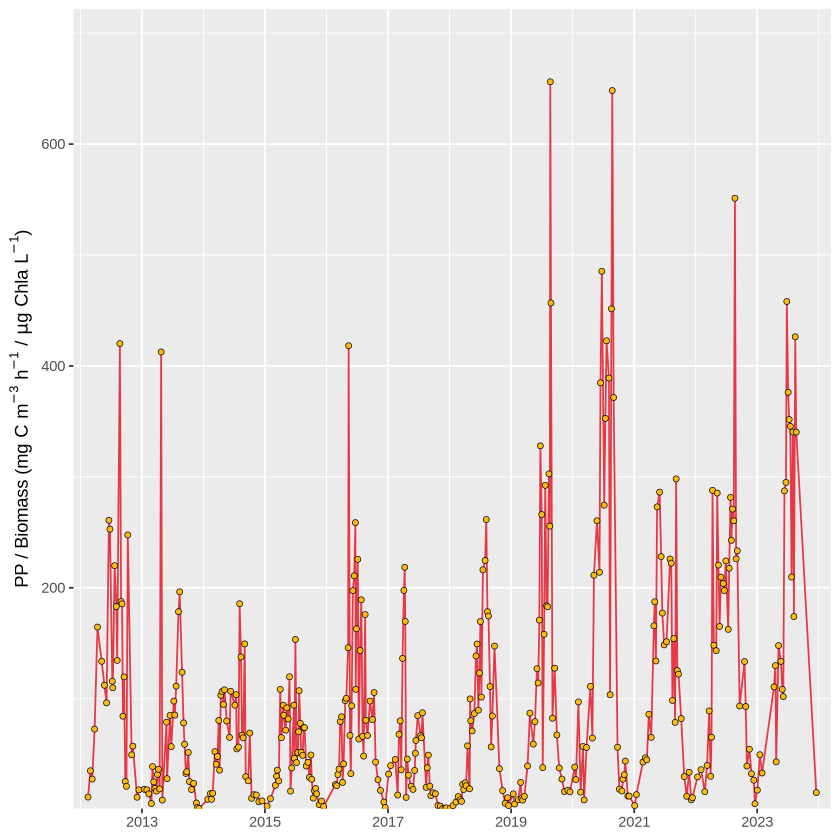

In [44]:
## *Fig*. PP & Chla dynamics (2012-2024)


require(ggplot2)
require(lubridate)
require(dplyr)
require(mgcv)  # For GAM models
library(patchwork)

# Load and prepare data
PI_curve <- read.csv(paste(PI_output_dir, "output_JP_v2.csv", sep = "")) %>%
  mutate(datum = ymd_hms(datum),
         I_opt = P_max / alpha)

Jetty_df <- read.csv(
  file = paste(wd_path, "/processed_data/", "Jetty_HWseries.csv", sep = ""),
  fileEncoding = "UTF-8",
  na.strings = c("", "NA"),
  header = TRUE
) %>%
  mutate(timestamp = ymd_hms(timestamp))

# Merge datasets
PI_Jetty <- merge(PI_curve, Jetty_df, by.x = "HWcode", by.y = "SampleID") %>%
  mutate(Date = as.Date(datum),
         day_of_year = yday(datum),
         DIN = NH4 + NO3 + NO2)

sumDay_PP_total <- read.csv(file = paste(wd_path, "/PP_cal/", "sumDay_PP_JP.csv", sep = "")) %>%
  mutate(date = ymd(as.character(date)))
sumYear_PP_total <- aggregate(sumDay_PP_total$daily_PP, by=list(year(sumDay_PP_total$date)),FUN=sum)
names(sumYear_PP_total) <- c("Year","PP_sumYear")
sumYear_PP_total <- sumYear_PP_total[which(sumYear_PP_total$Year!=2024),]

HW_PP <- merge(PI_Jetty, sumDay_PP_total, by.x = "Date", by.y = "date")

sumDay_PP_total$date <- ymd(sumDay_PP_total$date)
sumDay_PP_total$doy <- yday(sumDay_PP_total$date)

sumDay_PP_total$daily_PP[sumDay_PP_total$daily_PP <= 0] <- 0.001

gam_model <- gam(daily_PP ~ s(doy, bs = "tp", k=10), 
                 family = Gamma(link = "log"), 
                 data = sumDay_PP_total)

gam_pred <- predict(gam_model, 
                    newdata = sumDay_PP_total,
                    type="link",se.fit = TRUE)

# Predict values using the fitted model
sumDay_PP_total <- sumDay_PP_total%>%
  mutate(
    Fitted = exp(gam_pred$fit),
    lower_ci = exp(gam_pred$fit - 1.96*gam_pred$se.fit),
    upper_ci = exp(gam_pred$fit + 1.96*gam_pred$se.fit)
  )

summary(gam_model) # 0.405   
AIC(gam_model)

# ==================== PANEL A: TIME SERIES ====================
library(ggplot2)
library(patchwork)

# ==================== PANEL A: PRIMARY PRODUCTION ====================
PP_ts <- ggplot(sumDay_PP_total, aes(x = date, y = daily_PP)) +
  geom_line(linewidth = 0.5, color = "#1E88E5") +
  geom_point(data = HW_PP, aes(x = Date, y = daily_PP), 
             size = 1.5, shape = 21, fill = "#FFC107", color = "black", stroke = 0.3) +
  labs(
    y = expression(Primary~Production~(mg~C~m^{-2}~day^{-1})),
    x = NULL
  ) +
  scale_x_date(
    date_breaks = "2 years",
    date_labels = "%Y",
    expand = c(0.02, 0.02)
  ) +
  scale_y_continuous(
    expand = expansion(mult = c(0, 0.1)),
    limits = c(0, NA)
  ) 


Nut_Light_limitation_df <- read.csv(paste(PP_cal_dir,"Nut_Light_limitation_Jetty40.csv",sep=""))
Nut_Light_limitation_df$Lim_Nut <- factor(Nut_Light_limitation_df$Lim_Nut, levels=c("DIN","DP","DSi"))
Nut_Light_limitation_df$date<-Nut_Light_limitation_df$date%>%as.Date()


# ==================== PANEL A: TIME SERIES ====================
library(ggplot2)
library(patchwork)

# Merge the two datasets by date
df_combined <- merge(
  PI_Jetty[, c("Date", "Chl")],
  Nut_Light_limitation_df[, c("date", "mu")],
  by.x = "Date", by.y = "date",
  all = TRUE
)

# Reverse Chl range and get growth rate range
chl_range <- range(df_combined$Chl, na.rm = TRUE)*1.1
mu_range  <- range(df_combined$mu, na.rm = TRUE)*1.1

# NOTE: since we reverse Chl visually, its lower value is plotted higher.
# So: match min(Chl) to top and max(Chl) to bottom.

# Rescaling factor for mu → reversed Chl scale
scale_factor <- diff(rev(chl_range)) / diff(mu_range)

# Rescale growth rate to reversed Chl scale
df_combined$mu_rescaled <- (df_combined$mu - mu_range[1]) * scale_factor + chl_range[2]

# Plot
Chla_growth_ts <- ggplot(df_combined, aes(x = Date)) +
  # Chl-a (left axis, reversed)
  geom_line(aes(y = Chl), linewidth = 0.5, color = "#006400") +
  geom_point(aes(y = Chl), size = 1.5, shape = 21, fill = "#006400", color = "black", stroke = 0.3) +
  # Growth rate (on rescaled scale)
  geom_line(aes(y = mu_rescaled), linewidth = 0.5, color = "#E63946") +
  geom_point(aes(y = mu_rescaled), size = 1.5, shape = 21, fill = "#E63946", color = "black", stroke = 0.3) +
  labs(
    y = expression("Biomass (mg Chl-a m"^{-3}*")"),
    x = NULL
  ) +
  scale_x_date(
    date_breaks = "2 years",
    date_labels = "%Y",
    expand = c(0.02, 0.02)
  ) +
  scale_y_reverse(  # primary (left) axis: Chl-a reversed
    expand = expansion(mult = c(0, 0.1)),
    sec.axis = sec_axis(
      # rescale from reversed Chl scale back to growth rate
      ~ (.- chl_range[2]) / scale_factor + mu_range[1],
      name = expression("Growth rate ("*d^{-1}*")")
    )
  ) 

Chla_growth_ts <- Chla_growth_ts +
  theme(
    axis.title.y = element_text(color = "#006400", size = 10),
    axis.title.y.right = element_text(color = "#E63946", size = 10)
  )






# ==================== COMBINE WITH PATCHWORK AND TAGS ====================
combined_plot <- PP_ts / Chla_growth_ts +
  plot_annotation(tag_levels = "A", tag_prefix = "(", tag_suffix = ")") &
  theme(
    plot.tag = element_text(face = "bold", hjust = 0, vjust = 1)
  )

combined_plot

# ==================== SAVE OUTPUT ====================
#ggsave(
#  filename = paste0(graph_dir, "PrimaryProduction_biomass_growth_Fig.tiff"),
#  plot = combined_plot,
#  device = "tiff",
#  width = 180,  # mm (standard width for 1-column figures)
#  height = 150, # mm
#  units = "mm",
#  dpi = 600,
#  compression = "lzw",
#  bg="white"
#)


# Compute ratio and add to dataframe
PI_Jetty$Date <- as.Date(PI_Jetty$Date)
PI_Jetty$PP_Chl_ratio <- HW_PP$daily_PP / PI_Jetty$Chl

PP_Chl_ts <- ggplot(PI_Jetty, aes(x = Date, y = PP_Chl_ratio)) +
  geom_line(linewidth = 0.5, color = "#E63946") +
  geom_point(aes(x = Date, y = PP_Chl_ratio), 
             size = 1.5, shape = 21, fill = "#FDB813", color = "black", stroke = 0.3) +
  labs(
    y = expression("PP / Biomass ("*mg~C~m^{-3}~h^{-1}~"/"~mu*g~Chl*a~L^{-1}*")"),
    x = NULL
  ) +
  scale_x_date(
    date_breaks = "2 years",
    date_labels = "%Y",
    expand = c(0.02, 0.02)
  ) +
  scale_y_continuous(
    expand = expansion(mult = c(0, 0.1))
  )

PP_Chl_ts
# ggsave(
#   filename = paste0(graph_dir, "PrimaryProduction_BiomassRatio_Fig.png"),
#   plot = PP_Chl_ts,
#   device = "png",
#   width = 180,  # mm (standard width for 1-column figures)
#   height = 75, # mm
#   units = "mm",
#   dpi = 600,
#   bg = "white"
# )

# Or, if focusing on 2018 onward:
PI_Jetty_post2018 <- PI_Jetty %>% filter(year_frac >= 2018)

# Add a fractional year column
PI_Jetty$year <- year(PI_Jetty$datum)
# + (yday(PI_Jetty$datum) - 1) / 365
model_full <- lm(PP_Chl_ratio ~ year, data = PI_Jetty)
summary(model_full)

PI_Jetty$PP_Chl_ratio[which(PI_Jetty$year==2018)]%>%mean

PI_Jetty$post2018 <- ifelse(PI_Jetty$datum%>%year > 2018, "Y", "N")

lm(Chl~post2018, data = PI_Jetty)%>%summary

Nut_Light_limitation_df$post2018  <- ifelse(Nut_Light_limitation_df$year > 2018, "Y", "N")
lm(mu~post2018, data = Nut_Light_limitation_df)%>%summary
aov(mu~post2018, data = Nut_Light_limitation_df)%>%summary


Warning message in sqrt(PI_curve$a_fit * PI_curve$c_fit):
“NaNs produced”
Warning message in sqrt(PI_curve$c_fit/PI_curve$a_fit):
“NaNs produced”



Family: Gamma 
Link function: log 

Formula:
daily_PP ~ s(doy, bs = "tp")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.72254    0.01351   423.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
         edf Ref.df    F p-value    
s(doy) 8.937  8.999 1179  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.405   Deviance explained = 67.4%
GCV = 0.63111  Scale est. = 0.80001   n = 4383

[1] 58524.99


Family: Gamma 
Link function: log 

Formula:
Chl ~ s(doy, bs = "tp")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.94396    0.03218   60.41   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
         edf Ref.df     F p-value    
s(doy) 8.643  8.963 35.18  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.22   Deviance explained = 46.1%
GCV = 0.36535  Scale est. = 0.48769   n = 471

[1] 2591.355

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'doy'. You can override using the `.groups`
argument.


4381 
   2

4383 
   1

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”


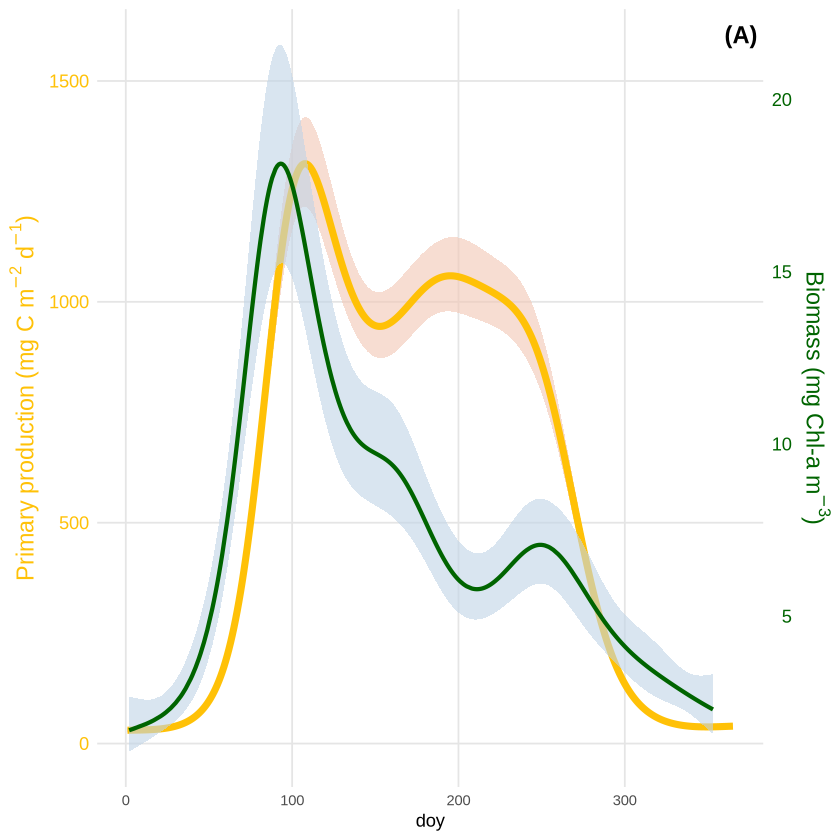

In [49]:
## *Fig* Seanality of PP & Biomass

require(dplyr)
require(ggplot2)
library(patchwork)
library(mgcv)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(plotly)
library(pracma)

Nut_Light_limitation_df <- read.csv(paste(PP_cal_dir,"Nut_Light_limitation_Jetty40.csv",sep=""))
Nut_Light_limitation_df$Lim_Nut <- factor(Nut_Light_limitation_df$Lim_Nut, levels=c("DIN","DP","DSi"))

# load Eilers-Peeters a, b, c parameters
PI_curve <- read.csv(paste(PI_output_dir,"output_v2.csv",sep=""))
PI_curve <- PI_curve[,c("datum", "HWcode", "a_fit", "b_fit", "c_fit")]
PI_curve$P_max = 1/(2*sqrt(PI_curve$a_fit*PI_curve$c_fit)+PI_curve$b_fit) # maximum productivity in mg C/mg chla/h
PI_curve$I_opt = sqrt(PI_curve$c_fit/PI_curve$a_fit) # optimum light intensity in uE/m2/s
PI_curve$initial_slop = 1/PI_curve$c_fit

PI_curve$datum <- PI_curve$datum%>%ymd_hms


# Plotting PP against day of years
sumDay_PP_total <- read.csv(file = paste(wd_path,"/PP_cal/","sumDay_PP.csv",sep=""))
sumDay_PP_total$date <- ymd(sumDay_PP_total$date)
sumDay_PP_total$doy <- yday(sumDay_PP_total$date)

sumDay_PP_total$daily_PP[sumDay_PP_total$daily_PP <= 0] <- 0.001

Jetty_df = read.csv(file=paste(wd_path,"/processed_data/","Jetty_HWseries.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
Jetty_df$timestamp <- Jetty_df$timestamp%>%ymd_hms()
Jetty_df$doy <- yday(Jetty_df$timestamp)
Jetty_df$Day <- yday(Jetty_df$timestamp)
Jetty_df$Year <- year(Jetty_df$timestamp)
Jetty_df$DIN <- Jetty_df$NH4 + Jetty_df$NO2 + Jetty_df$NO3

Chla_1974_2012 = read.csv(file=paste(wd_path,"/rawdata/","Chla_CovertHPLC_1974_2012.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
Chla_1974_2012$date_descr <- dmy(Chla_1974_2012$date_descr)

Jetty_df$Chl[which(Jetty_df$Year>=1990&Jetty_df$Year<=2011)] = Chla_1974_2012$HPLC_convmeas[which(year(Chla_1974_2012$date_descr)>=1990&year(Chla_1974_2012$date_descr)<=2011)] # replace Spectrophotometry-Chla with Converted HPLC-Chla (based on emperical relationship, HPLC-C ~ 0.83 * Spect-Chla)

gam_model <- gam(daily_PP ~ s(doy, bs = "tp"), 
                 family = Gamma(link = "log"), 
                 data = sumDay_PP_total)

gam_pred <- predict(gam_model, 
                    newdata = sumDay_PP_total,
                    type="link",se.fit = TRUE)

# Predict values using the fitted model
sumDay_PP_total <- sumDay_PP_total%>%
  mutate(
    Fitted = exp(gam_pred$fit),
    lower_ci = exp(gam_pred$fit - 1.96*gam_pred$se.fit),
    upper_ci = exp(gam_pred$fit + 1.96*gam_pred$se.fit)
  )



Jetty_df_2012_2023 <- Jetty_df[which(Jetty_df$Year>=2012&Jetty_df$Year<=2023),]
Chl_gam_model <- gam(Chl ~ s(doy, bs = "tp"), 
                     family = Gamma(link = "log"), 
                     data = Jetty_df_2012_2023)

Chl_gam_pred <- predict(Chl_gam_model, 
                        newdata = Jetty_df_2012_2023,
                        type="link",se.fit = TRUE)

# Predict values using the fitted model
sumDay_PP_total <- sumDay_PP_total%>%
  mutate(
    Fitted = exp(gam_pred$fit),
    lower_ci = exp(gam_pred$fit - 1.96*gam_pred$se.fit),
    upper_ci = exp(gam_pred$fit + 1.96*gam_pred$se.fit)
  )

Jetty_df_2012_2023 <- Jetty_df_2012_2023%>%
  mutate(
    Fitted = exp(Chl_gam_pred$fit),
    lower_ci = exp(Chl_gam_pred$fit - 1.96*Chl_gam_pred$se.fit),
    upper_ci = exp(Chl_gam_pred$fit + 1.96*Chl_gam_pred$se.fit)
  )

summary(gam_model) # 0.405   
AIC(gam_model)

summary(Chl_gam_model)
AIC(Chl_gam_model)

sumDay_PP_doy <- sumDay_PP_total%>%group_by(doy)%>%summarize(Fitted_PP = unique(Fitted))

sumDay_PP_doy <- sumDay_PP_doy %>% arrange(doy) %>% mutate(DailyChange=c(NA, diff(Fitted_PP)), DailyChangePercent = c(NA, diff(Fitted_PP)/Fitted_PP[-length(Fitted_PP)]*100))%>%na.omit

sumDay_PP_doy$DailyChangePercent %>% which.min
sumDay_PP_doy$DailyChangePercent %>% which.max

p0 <- ggplot(sumDay_PP_total, aes(x = doy)) +
  # Raw data points
  geom_point(aes(y = daily_PP), 
             shape = 21, fill = "steelblue", color = "white", 
             size = 2, alpha = 0.7, stroke = 0.5) +
  # Fitted line
  geom_line(aes(y = Fitted), 
            color = "#E69F00", size = 1.2, lineend = "round") +
  # Vertical reference lines
  geom_vline(xintercept = c(sumDay_PP_doy$doy[which.max(sumDay_PP_doy$DailyChangePercent)],
                            sumDay_PP_doy$doy[which.min(sumDay_PP_doy$DailyChangePercent)]), 
             linetype = "dashed", color = "gray30", size = 0.8) +
  geom_ribbon(aes(ymin = lower_ci, ymax = upper_ci), 
              fill = "grey", alpha = 0.8) +
  labs(title = "Daily primary production over day of year (2012-2023)",
       y = "daily primary production (mgC/m²/d)") +
  # Axis scales
  scale_x_continuous(
    limits = c(1, 365),
    breaks = seq(15, 345, by = 30),  # Center month labels
    labels = month.abb[1:12],        # Standard month abbreviations
    expand = c(0.01, 0.01)          # Tighten axis padding
  )  + theme_minimal() +
  theme(
    text = element_text(family = "sans"),
    axis.title.x = element_blank(),
    axis.text.x = element_text(size = 10, color = "black"),
    axis.title.y = element_text(size = 12, face = "bold"),
    axis.text.y = element_text(size = 10),
    panel.grid.major = element_line(color = "gray90", linewidth = 0.25),
    panel.grid.minor = element_blank(),
    plot.title = element_blank()  # Removed as caption typically goes in manuscript
  )

# ggsave(
#   filename = file.path(graph_dir, "PP_GAM_ts.png"),
#   plot = p0,
#   device = "png",
#   width = 7,       # Standard single-column width (inches)
#   height = 5,        # Adjusted height for better proportions
#   units = "in",
#   dpi = 600,         # Publication quality
#   bg = "white"
# )

# Color-blind safe palette
pp_color <- "#FFC107"

chla_color <- "#006400"   # Blue for Chla
pp_ribbon <- "#F2C6B4"    # Soft orange tint
chla_ribbon <- "#BFD3E6"  # Soft blue tint

# Normalize Pilot_chla for plotting on same axis
range_PP <- range(sumDay_PP_total$Fitted, na.rm = TRUE)
range_chla <- range(Jetty_df_2012_2023$Fitted, na.rm = TRUE)

# Scale function for plotting
scale_chla_to_PP <- function(x) {
  (x - min(range_chla)) / diff(range_chla) * diff(range_PP) + min(range_PP)
}

# Inverse scale function for secondary axis
scale_PP_to_chla <- function(x) {
  (x - min(range_PP)) / diff(range_PP) * diff(range_chla) + min(range_chla)
}

# Add Pilot_chla to PP_plot
PP_plot <- ggplot(sumDay_PP_total, aes(x = doy)) +
  xlim(1, 365) +
  
  # Error ribbon for PP
  geom_ribbon(data = sumDay_PP_total, 
              aes(ymin = lower_ci, ymax = upper_ci), 
              fill = pp_ribbon, alpha = 0.6) +
  
  # PP line
  geom_line(data = sumDay_PP_total, 
            aes(y = Fitted), 
            color = pp_color, size = 2) +
  
  # Error ribbon for scaled chla
  geom_ribbon(data = Jetty_df_2012_2023, 
              aes(ymin = scale_chla_to_PP(lower_ci), ymax = scale_chla_to_PP(upper_ci)), 
              fill = chla_ribbon, alpha = 0.6) +
  
  # Chla line
  geom_line(data = Jetty_df_2012_2023, 
            aes(x = doy, y = scale_chla_to_PP(Fitted)), 
            color = chla_color, size = 1.2) +
  
  # Y-axes
  scale_y_continuous(
    name = expression("Primary production (" * mg~C~m^{-2}~d^{-1} * ")"),
    sec.axis = sec_axis(~scale_PP_to_chla(.), 
                        # name = expression("Biomass, Chl-a (" * mg~m^{-3} * ")")
                        name = expression("Biomass (mg Chl-a m"^{-3}*")")
                          )
  ) +
  theme_minimal() +
  theme(
    # axis.title.x = element_blank(),
    # axis.text.x = element_blank(),
    axis.title.y.left = element_text(size = 14, face = "bold", color = pp_color),
    axis.title.y.right = element_text(size = 14, face = "bold", color = chla_color),
    axis.text.y.left = element_text(size = 11, color = pp_color),
    axis.text.y.right = element_text(size = 11, color = chla_color),
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    panel.grid.major = element_line(color = "gray90"),
    panel.grid.minor = element_blank()
  )
PP_plot

# Save the plot as a TIFF file
# tiff(filename = paste0(graph_dir, "PP_Chla_Timeseries.tiff"), 
#     width = 3000, height = 2000, res = 300)  # 300 dpi, suitable for publication
# print(PP_plot)
# dev.off()


Warning message in sqrt(PI_curve$a_fit * PI_curve$c_fit):
“NaNs produced”
Warning message in sqrt(PI_curve$c_fit/PI_curve$a_fit):
“NaNs produced”


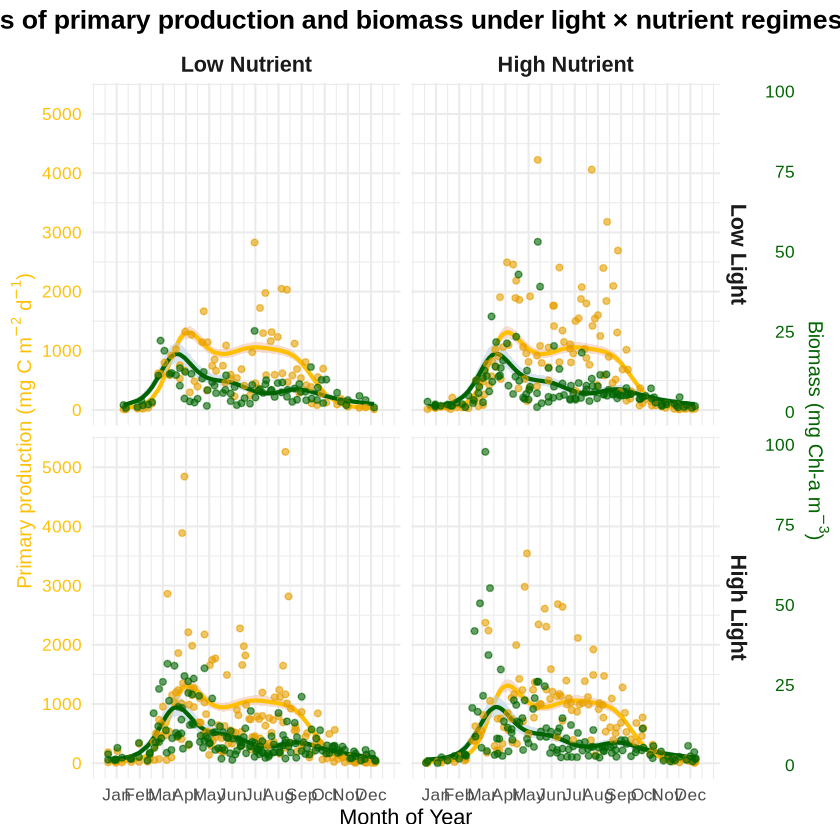

In [4]:
## *Fig* Four panels

# ---------------------------------------------------------
# 1. Data already loaded: comb_PP_Jetty
# ---------------------------------------------------------
require(dplyr)
require(ggplot2)
library(patchwork)
library(mgcv)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(plotly)
library(pracma)

Nut_Light_limitation_df <- read.csv(paste(PP_cal_dir,"Nut_Light_limitation_Jetty40.csv",sep=""))
Nut_Light_limitation_df$Lim_Nut <- factor(Nut_Light_limitation_df$Lim_Nut, levels=c("DIN","DP","DSi"))

# load Eilers-Peeters a, b, c parameters
PI_curve <- read.csv(paste(PI_output_dir,"output_v2.csv",sep=""))
PI_curve <- PI_curve[,c("datum", "HWcode", "a_fit", "b_fit", "c_fit")]
PI_curve$P_max = 1/(2*sqrt(PI_curve$a_fit*PI_curve$c_fit)+PI_curve$b_fit) # maximum productivity in mg C/mg chla/h
PI_curve$I_opt = sqrt(PI_curve$c_fit/PI_curve$a_fit) # optimum light intensity in uE/m2/s
PI_curve$initial_slop = 1/PI_curve$c_fit

PI_curve$datum <- PI_curve$datum%>%ymd_hms


# Plotting PP against day of years
sumDay_PP_total <- read.csv(file = paste(wd_path,"/PP_cal/","sumDay_PP.csv",sep=""))
sumDay_PP_total$date <- ymd(sumDay_PP_total$date)
sumDay_PP_total$doy <- yday(sumDay_PP_total$date)

sumDay_PP_total$daily_PP[sumDay_PP_total$daily_PP <= 0] <- 0.001

Jetty_df = read.csv(file=paste(wd_path,"/processed_data/","Jetty_HWseries.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
Jetty_df$timestamp <- Jetty_df$timestamp%>%ymd_hms()
Jetty_df$doy <- yday(Jetty_df$timestamp)
Jetty_df$Day <- yday(Jetty_df$timestamp)
Jetty_df$Year <- year(Jetty_df$timestamp)
Jetty_df$DIN <- Jetty_df$NH4 + Jetty_df$NO2 + Jetty_df$NO3

Chla_1974_2012 = read.csv(file=paste(wd_path,"/rawdata/","Chla_CovertHPLC_1974_2012.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
Chla_1974_2012$date_descr <- dmy(Chla_1974_2012$date_descr)

Jetty_df$Chl[which(Jetty_df$Year>=1990&Jetty_df$Year<=2011)] = Chla_1974_2012$HPLC_convmeas[which(year(Chla_1974_2012$date_descr)>=1990&year(Chla_1974_2012$date_descr)<=2011)] # replace Spectrophotometry-Chla with Converted HPLC-Chla (based on emperical relationship, HPLC-C ~ 0.83 * Spect-Chla)

gam_model <- gam(daily_PP ~ s(doy, bs = "tp"), 
                 family = Gamma(link = "log"), 
                 data = sumDay_PP_total)

gam_pred <- predict(gam_model, 
                    newdata = sumDay_PP_total,
                    type="link",se.fit = TRUE)


Jetty_df_2012_2023 <- Jetty_df[which(Jetty_df$Year>=2012&Jetty_df$Year<=2023),]
Chl_gam_model <- gam(Chl ~ s(doy, bs = "tp"), 
                     family = Gamma(link = "log"), 
                     data = Jetty_df_2012_2023)

Chl_gam_pred <- predict(Chl_gam_model, 
                        newdata = Jetty_df_2012_2023,
                        type="link",se.fit = TRUE)

# Predict values using the fitted model
sumDay_PP_total <- sumDay_PP_total%>%
  mutate(
    PP_Fitted = exp(gam_pred$fit),
    PP_lower_ci = exp(gam_pred$fit - 1.96*gam_pred$se.fit),
    PP_upper_ci = exp(gam_pred$fit + 1.96*gam_pred$se.fit)
  )

Jetty_df_2012_2023 <- Jetty_df_2012_2023%>%
  mutate(
    Chl_Fitted = exp(Chl_gam_pred$fit),
    Chl_lower_ci = exp(Chl_gam_pred$fit - 1.96*Chl_gam_pred$se.fit),
    Chl_upper_ci = exp(Chl_gam_pred$fit + 1.96*Chl_gam_pred$se.fit)
  )


# ---------------------------------------------------------
# 2. Define scaling functions for dual y-axis
# ---------------------------------------------------------

# Compute long-term average for light and nutrients
mean_light_12yr  <- mean(Jetty_df_2012_2023$SecchiDepth, na.rm = TRUE)     # replace PAR with your light variable name
mean_DIN_12yr    <- mean(Jetty_df_2012_2023$DIN, na.rm = TRUE)     # nutrients (DIN)

# Assign condition categories
yearly_means <- Jetty_df_2012_2023 %>% 
  mutate(Year = year(timestamp)) %>% 
  group_by(Year) %>% 
  summarise(
    mean_light_year = mean(SecchiDepth, na.rm = TRUE),
    mean_DIN_year = mean(DIN, na.rm=TRUE)
  ) %>% 
  mutate(
    LightCat = ifelse(mean_light_year >= mean_light_12yr, "High Light", "Low Light"),
    NutCat   = ifelse(mean_DIN_year >= mean_DIN_12yr, "High Nutrient", "Low Nutrient"),
    Combo    = paste(LightCat, NutCat, sep = " & ")
  )

# ---------------------------------------------------------
# 3️⃣ Join yearly category info back to *all individual points*
# ---------------------------------------------------------
Jetty_Cat <- Jetty_df_2012_2023 %>%
  mutate(Year = year(timestamp)) %>%
  left_join(
    yearly_means %>% select(Year, LightCat, NutCat, Combo),
    by = "Year"
  )

# Combine the categories into the PP dataset too (align by date if possible)
comb_PP_Jetty <- sumDay_PP_total %>%
  mutate(date = as.Date(date)) %>%
  left_join(Jetty_Cat %>%
              select(timestamp, Chl, doy, Kd_Secci, Chl_Fitted, Chl_lower_ci, Chl_upper_ci, LightCat, NutCat, Combo) %>%
              mutate(date = as.Date(timestamp)) %>%
              distinct(date, .keep_all = TRUE),
            by = c("date", "doy"))%>%na.omit



range_PP <- range(comb_PP_Jetty$daily_PP, na.rm = TRUE)
range_chla <- range(comb_PP_Jetty$Chl, na.rm = TRUE)  # if you have separate Fitted_Chl, replace here

scale_chla_to_PP <- function(x) {
  (x - min(range_chla)) / diff(range_chla) * diff(range_PP) + min(range_PP)
}
scale_PP_to_chla <- function(x) {
  (x - min(range_PP)) / diff(range_PP) * diff(range_chla) + min(range_chla)
}

# ---------------------------------------------------------
# 3. Plotting function (GLOBAL fits + PANEL-specific points)
# ---------------------------------------------------------

# ---------------------------------------------------------
# Ensure facet order: Low on bottom/left
# ---------------------------------------------------------
comb_PP_Jetty <- comb_PP_Jetty %>%
  mutate(
    LightCat = factor(LightCat, levels = c("Low Light", "High Light")),
    NutCat   = factor(NutCat,   levels = c("Low Nutrient", "High Nutrient"))
  )

# ---------------------------------------------------------
# Plot all panels together (shared scales)
# ---------------------------------------------------------
p_all <- ggplot() +
  # Global PP GAM ribbon + line
  geom_ribbon(data = comb_PP_Jetty,
              aes(x = doy, ymin = PP_lower_ci, ymax = PP_upper_ci),
              fill = "#F2C6B4", alpha = 0.6) +
  geom_line(data = comb_PP_Jetty,
            aes(x = doy, y = PP_Fitted),
            color = "#FFC107", size = 1.2) +
  
  # Global Chl GAM ribbon + line (scaled)
  geom_ribbon(data = comb_PP_Jetty,
              aes(x = doy,
                  ymin = scale_chla_to_PP(Chl_lower_ci),
                  ymax = scale_chla_to_PP(Chl_upper_ci)),
              fill = "#BFD3E6", alpha = 0.6) +
  geom_line(data = comb_PP_Jetty,
            aes(x = doy, y = scale_chla_to_PP(Chl_Fitted)),
            color = "#006400", size = 1.2) +
  
  # Scatter points for each panel (yearly category)
  geom_point(data = comb_PP_Jetty,
             aes(x = doy, y = daily_PP),
             color = "#E69F00", size = 1.5, alpha = 0.6) +
  geom_point(data = comb_PP_Jetty,
             aes(x = doy, y = scale_chla_to_PP(Chl)),
             color = "#006400", size = 1.5, alpha = 0.6) +
  
  # Shared axes
  scale_x_continuous(
    limits = c(1, 365),
    breaks = seq(15, 345, by = 30),
    labels = month.abb
  ) +
  scale_y_continuous(
    name = expression("Primary production (" * mg~C~m^{-2}~d^{-1} * ")"),
    sec.axis = sec_axis(~scale_PP_to_chla(.),
                        name = expression("Biomass (mg Chl-a m"^{-3}*")"))
  ) +
  
  # Four panels (shared x/y scales)
  facet_grid(rows = vars(LightCat),
             cols = vars(NutCat),
             scales = "fixed") +
  
  labs(
    x = "Month of Year",
    title = "Seasonal cycles of primary production and biomass under light × nutrient regimes (2012–2023)"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.title.y.left  = element_text(size = 12, color = "#FFC107", face = "bold"),
    axis.title.y.right = element_text(size = 12, color = "#006400", face = "bold"),
    axis.text.y.left   = element_text(color = "#FFC107"),
    axis.text.y.right  = element_text(color = "#006400"),
    strip.text         = element_text(size = 13, face = "bold"),
    plot.title         = element_text(hjust = 0.5, face = "bold", size = 16)
  )

p_all

# Optionally save
# ggsave(file.path(graph_dir, "PP_Chl_4panel_conditions_points.png"),
#       p_all, width = 12, height = 8, dpi = 600, bg = "white")



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Warning message in sqrt(PI_curve$a_fit * PI_curve$c_fit):
“NaNs produced”
Warning message in sqrt(PI_curve$c_fit/PI_curve$a_fit):
“NaNs produced”


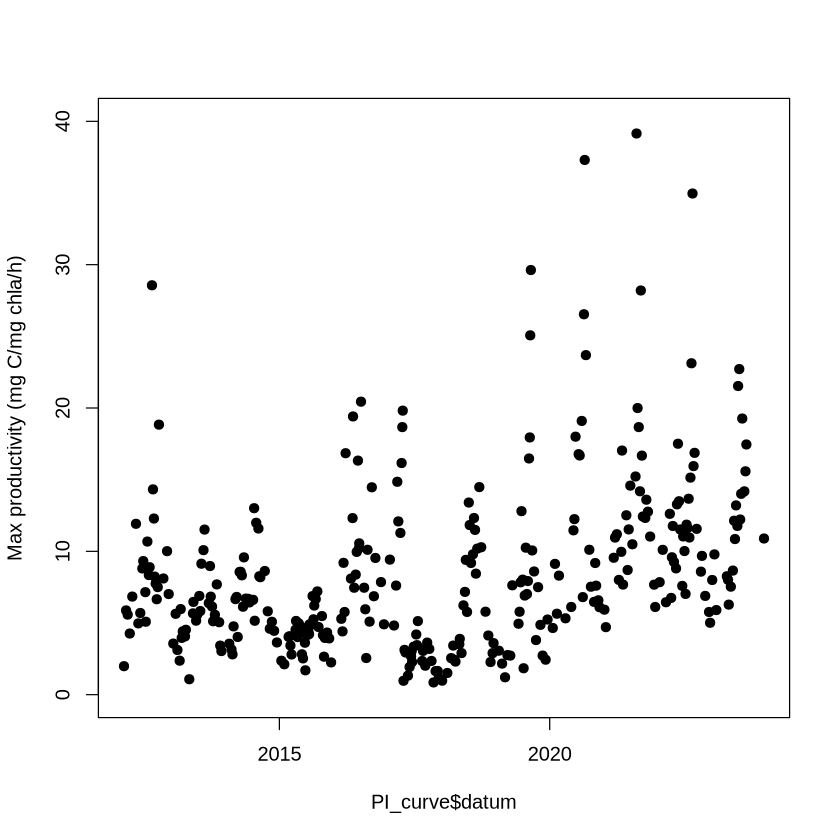

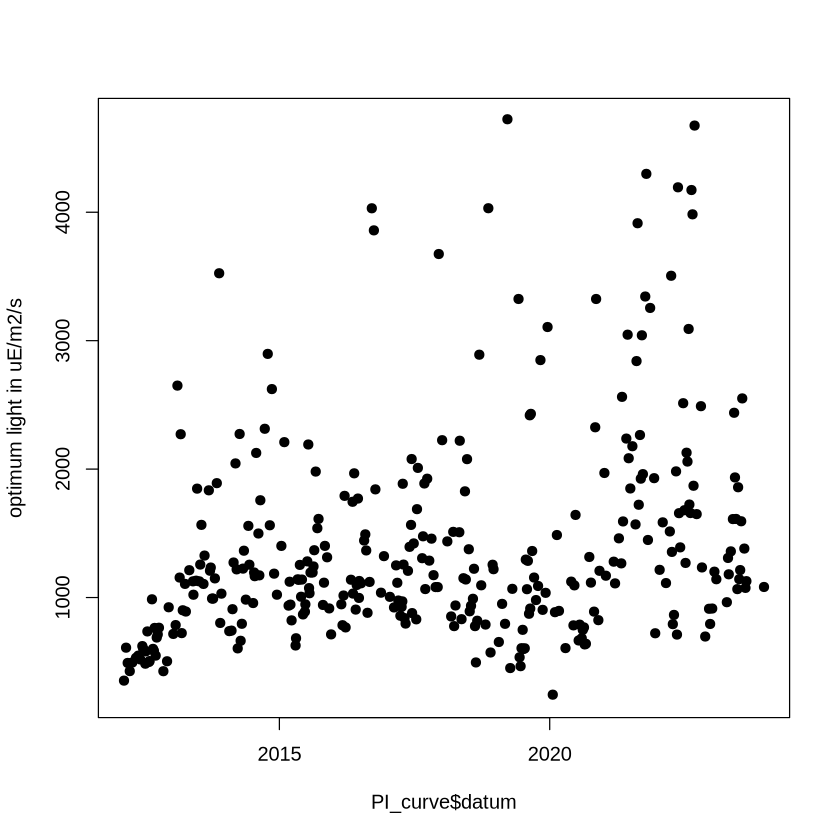

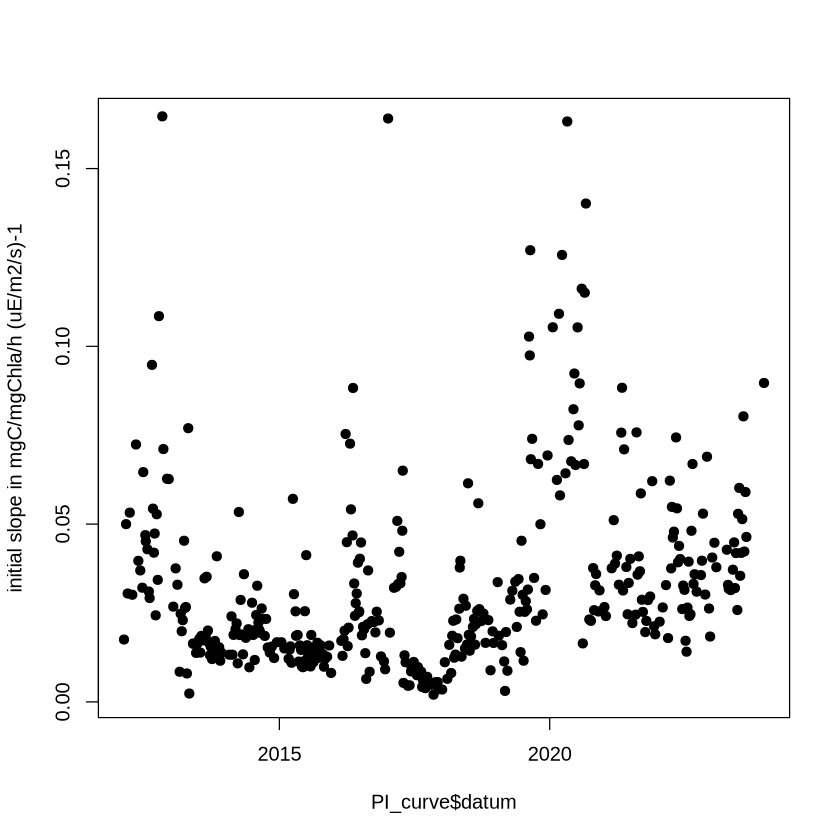

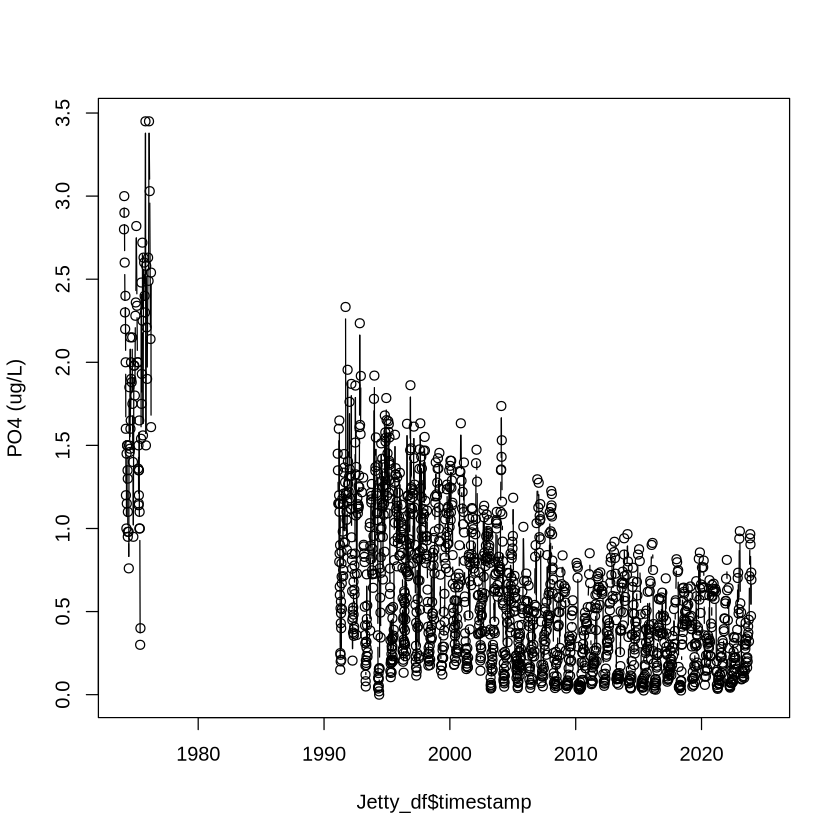

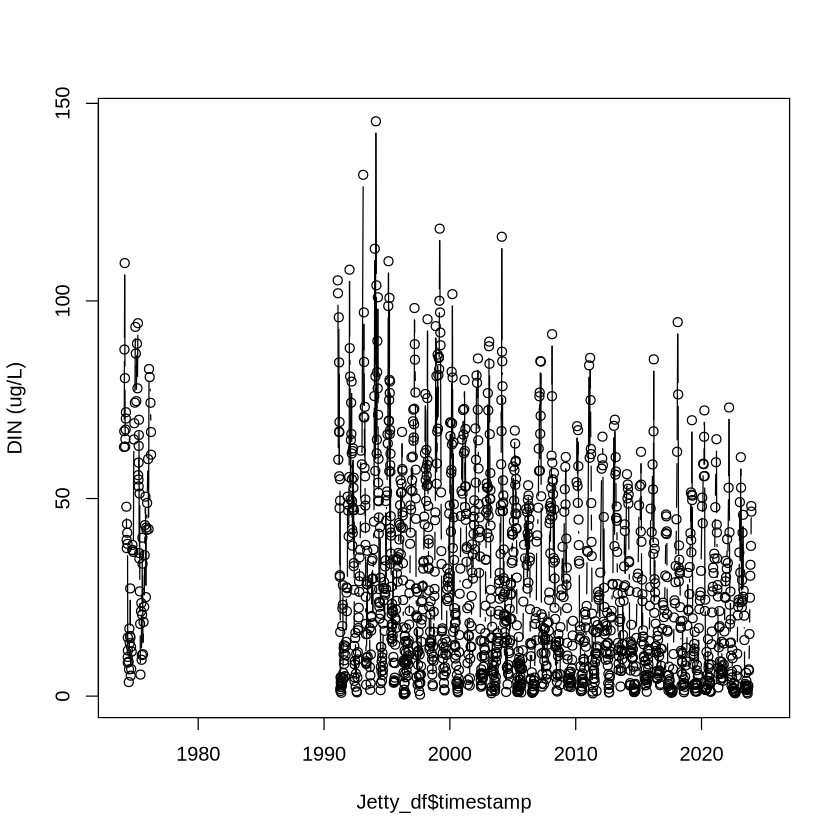

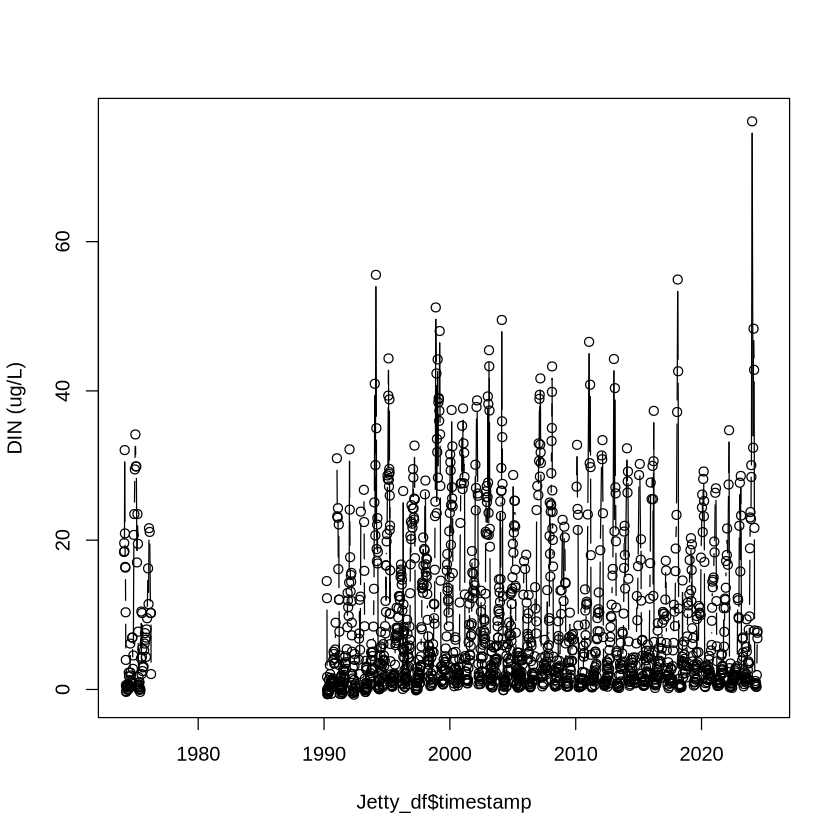

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


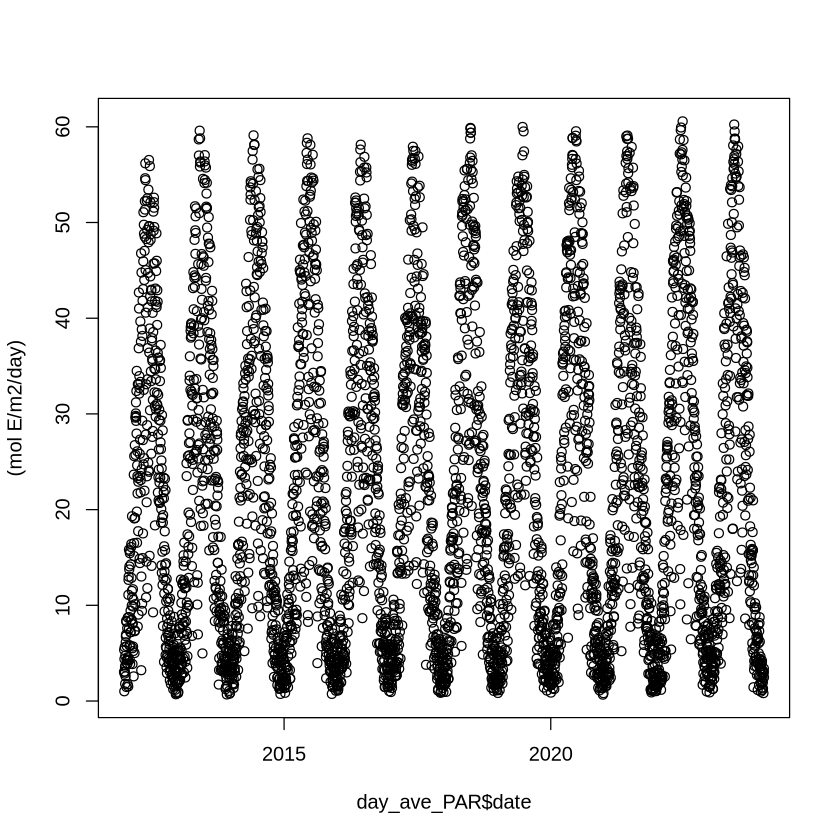

Warning message:
“Duplicated `override.aes` is ignored.”


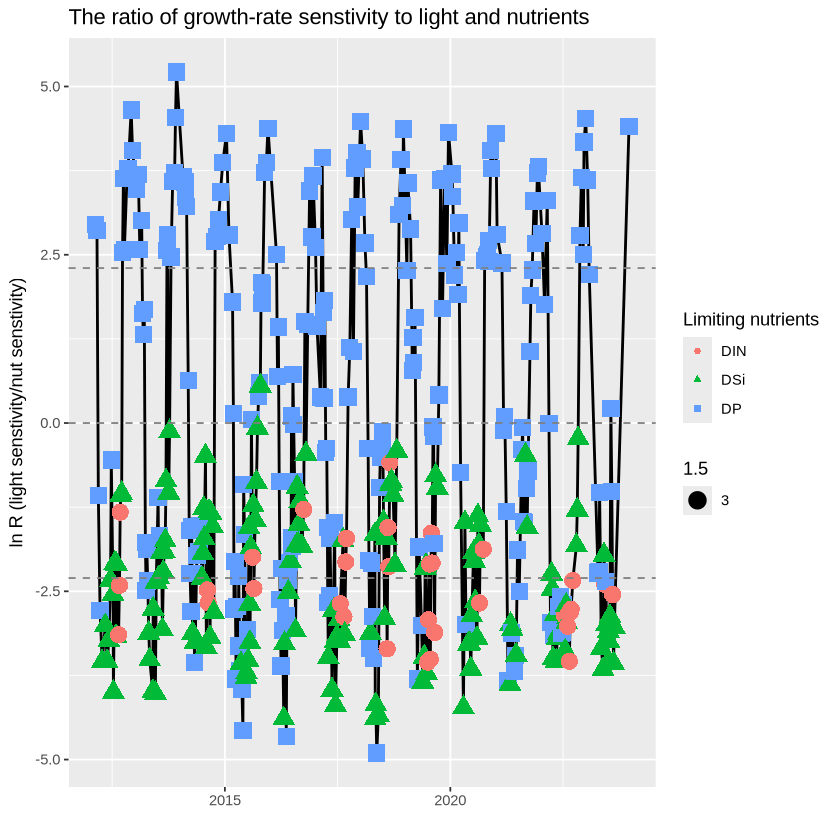

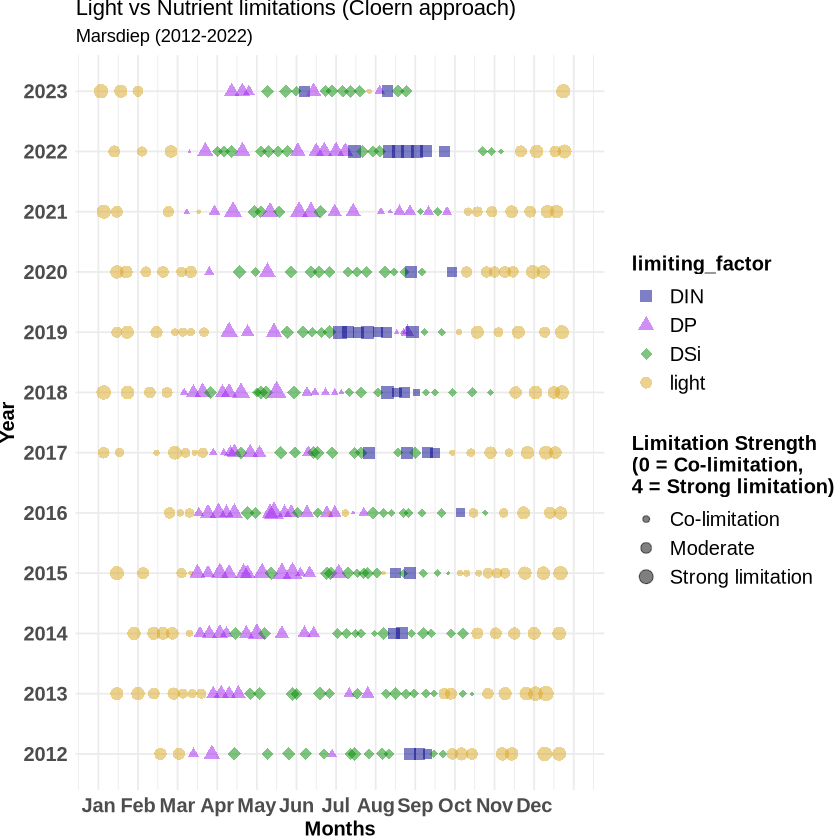

In [8]:
# 4. Light vs nutrient limitation
## 4.1 Cloern approach using 40

require(dplyr)
require(ggplot2)
library(lubridate)
library(ggplot2)
library(zoo)

# load Eilers-Peeters a, b, c parameters
PI_curve <- read.csv(paste(PI_output_dir,"output_v2.csv",sep=""))
PI_curve <- PI_curve[,c("datum", "HWcode", "a_fit", "b_fit", "c_fit")]
PI_curve$P_max = 1/(2*sqrt(PI_curve$a_fit*PI_curve$c_fit)+PI_curve$b_fit) # maximum productivity in mg C/mg chla/h
PI_curve$I_opt = sqrt(PI_curve$c_fit/PI_curve$a_fit) # optimum light intensity in uE/m2/s
PI_curve$initial_slop = 1/PI_curve$c_fit

PI_curve$datum <- PI_curve$datum%>%ymd_hms
names(PI_curve)[3:5] = c("PI_a", "PI_b", "PI_c")

plot(PI_curve$datum, PI_curve$P_max, ylim=c(0,40), pch=19, ylab="Max productivity (mg C/mg chla/h)")
plot(PI_curve$datum, PI_curve$I_opt, ylim=quantile(PI_curve$I_opt%>%na.omit, c(0,0.99)), pch=19, ylab="optimum light in uE/m2/s")
plot(PI_curve$datum, PI_curve$initial_slop, ylim=quantile(PI_curve$initial_slop%>%na.omit, c(0,0.99)), pch=19, ylab="initial slope in mgC/mgChla/h (uE/m2/s)-1")

Jetty_df = read.csv(file=paste(wd_path,"/processed_data/","Jetty_HWseries.csv",sep=""), fileEncoding = "UTF-8", na.strings=c("", "NA"), header=TRUE)
Jetty_df$timestamp <- Jetty_df$timestamp%>%ymd_hms()


plot(Jetty_df$timestamp,Jetty_df$PO4, ylab=c("PO4 (ug/L)"), t="b")
plot(Jetty_df$timestamp,Jetty_df$NO2+Jetty_df$NO3+Jetty_df$NH4, ylab=c("DIN (ug/L)"), t="b")
plot(Jetty_df$timestamp,Jetty_df$Si, ylab=c("DIN (ug/L)"), t="b")

PI_Jetty <- merge(PI_curve, Jetty_df, by.x="HWcode", by.y="SampleID")
PI_Jetty$DIN <- PI_Jetty$NH4 + PI_Jetty$NO3 + PI_Jetty$NO2

# Load necessary libraries
# Add a new column for the day of the year
PI_Jetty$day_of_year <- yday(PI_Jetty$datum)

PI_Jetty <- PI_Jetty %>%
  mutate(date = as.Date(datum),
         year = year(datum),
         month = month(datum)
  )

#######
# KNMI measurements
#######

hr_KNMI_filepath_2011_2020 <- paste(wd_path,"/rawdata/","uurgeg_235_2011-2020.txt",sep="")
hr_KNMI_filepath_2021_2030 <- paste(wd_path,"/rawdata/","uurgeg_235_2021-2030.txt",sep="")

hr_KNMI_deKooy_2011_20 <- read.table(hr_KNMI_filepath_2011_2020,header=TRUE, sep=",")
hr_KNMI_deKooy_2021_30 <- read.table(hr_KNMI_filepath_2021_2030, header=TRUE, sep=",")

hr_KNMI_deKooy <- rbind(hr_KNMI_deKooy_2011_20, hr_KNMI_deKooy_2021_30)

# hr_KNMI_deKooy$PAR = hr_KNMI_deKooy$Q*1e4/3600*2.515 # Conversion from KNMI 1J/(W m-2) to PAR (uE m-2 s-1), reference Brinkman et al., 2015, EMS-Dollard data report
hr_KNMI_deKooy$Datum <- paste(hr_KNMI_deKooy$YYYYMMDD, hr_KNMI_deKooy$HH,sep=" ")%>%ymd_h
hr_KNMI_deKooy <- hr_KNMI_deKooy[which(year(hr_KNMI_deKooy$Datum)%in%2012:2023),]

PAR_frac = 0.45  # PAR is 45% of global radiation
Reflec_frac = 0.07 # reflecting of solar radiation at the surface by 5-10%, ref Brinkman et al., 2015
hr_KNMI_deKooy$PAR = hr_KNMI_deKooy$Q*PAR_frac*(1-Reflec_frac) # in (J/cm2/h) over an hour at water surface

# convert to photon flux (uE m-2 s-1); reference Brinkman et al., 2015,    EMS-Dollard data report
sec_per_hr = 3600 # seconds in an hour
cm2_to_m2 = 1e4 
conversion_factor = 4.66 # (μE/m2/s)/(W/m2); reference Jacobs et al., 2021, https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0246012 (in Brinkman et al., 2015 data report this conversion factor is 2.515)

day_ave_PAR <- aggregate(hr_KNMI_deKooy$PAR, by = list(as.Date(hr_KNMI_deKooy$Datum)),FUN=mean) # in (J/cm2/h)
names(day_ave_PAR) <- c("date","PAR")
day_ave_PAR$I_surf <- day_ave_PAR$PAR/3600*3600*24*cm2_to_m2*conversion_factor*1e-6 # in (mol E/m2/day)

plot(day_ave_PAR$date, day_ave_PAR$I_surf, ylab="(mol E/m2/day)")

# Add a month column
day_ave_PAR <- day_ave_PAR[,c("date","I_surf")]
names(day_ave_PAR) <- c("date","irradiance")
day_ave_PAR <- day_ave_PAR %>%
  mutate(year = year(date),
         month = month(date)
  )


Nut_Light_limitation_df = merge(PI_Jetty,day_ave_PAR[,c("date","irradiance")], by.x = c("date"), by.y=c("date"))
Nut_Light_limitation_df = Nut_Light_limitation_df[,-which(names(Nut_Light_limitation_df)=="timestamp")]

# Define the integrate_primary_production function
integrate_primary_production <- function(z, PAR_daily, k, a, b, c) {
  light_hourly <- PAR_daily * 1e6 / (24 * 3600) # Convert from mol E/m2/day to umol E/m2/s
  light_at_depth <- light_hourly * exp(-k * z)
  production <- (light_at_depth / (a * light_at_depth^2 + b * light_at_depth + c)) * 24 # PP in mg C/m2/day
  return(production)
}

# Calcualate the average light over depth:
I_ave_depth <- function(PAR_daily, k, z) {
  I_mean_day_over_depth <- (PAR_daily / (k * z)) * (1 - exp(-(k * z)))
}

# Define the growth rate function

growth_rate <- function(PAR_daily, nutrient, Temp, k, a, b, c, Kn, z) {
  I_mean_day_over_depth <- (PAR_daily / (k * z)) * (1 - exp(-(k * z)))
  Chla_C <- 0.003 + 0.0154 * exp(0.050 * Temp) * exp(-0.059 * I_mean_day_over_depth) * (nutrient / (nutrient + Kn))
  
  # Depth-integrated primary production
  PP_over_depth <- integrate(integrate_primary_production, lower = 0, upper = z,
                             PAR_daily = PAR_daily, k = k, a = a, b = b, c = c)$value / z
  
  mu <- 0.85 * PP_over_depth * Chla_C - 0.015
  return(mu)
}

# Five-point formula for partial derivative with respect to light
partial_derivative_light <- function(light, nutrient, h, Temp, k, a, b, c, Kn, z) {
  (growth_rate(light * (1 - 2 * h), nutrient, Temp, k, a, b, c, Kn, z) -
     8 * growth_rate(light * (1 - h), nutrient, Temp, k, a, b, c, Kn, z) +
     8 * growth_rate(light * (1 + h), nutrient, Temp, k, a, b, c, Kn, z) -
     growth_rate(light * (1 + 2 * h), nutrient, Temp, k, a, b, c, Kn, z)) / (12 * h * light)
}

# Five-point formula for partial derivative with respect to nutrient
partial_derivative_nutrient <- function(light, nutrient, h, Temp, k, a, b, c, Kn, z) {
  (growth_rate(light, nutrient * (1 - 2 * h), Temp, k, a, b, c, Kn, z) -
     8 * growth_rate(light, nutrient * (1 - h), Temp, k, a, b, c, Kn, z) +
     8 * growth_rate(light, nutrient * (1 + h), Temp, k, a, b, c, Kn, z) -
     growth_rate(light, nutrient * (1 + 2 * h), Temp, k, a, b, c, Kn, z)) / (12 * h * nutrient)
}


Nut_Light_limitation_df <- Nut_Light_limitation_df %>%
  arrange(date) %>%
  mutate(
    across(
      .cols = -(1:3),  # all columns except the first two
      .fns  = ~ na.approx(., x = date, na.rm = FALSE)
    )
  )

# Nut_Light_limitation_df = na.omit(Nut_Light_limitation_df[,PP_input_vars])
names(Nut_Light_limitation_df)[which(names(Nut_Light_limitation_df)=="T")] <- "T_insitu" 
# Main loop for calculations

for (i in 1:nrow(Nut_Light_limitation_df)) {
  Date <- Nut_Light_limitation_df$date[i]
  Nuts <- c(DIN = Nut_Light_limitation_df$DIN[i], DSi = Nut_Light_limitation_df$Si[i], DP = Nut_Light_limitation_df$PO4[i])
  # Knuts <- c(K_N = 1.5, K_Si = 1.5, K_P = 0.15) # Cloern 1999 for K_N, and philippart et al., (2007) for the ratio between K_N/K_Si=1, K_N/K_P=10
  Knuts <- c(K_N = 2, K_Si = 2, K_P = 0.2) # Philippart et al., (2007)
  # Knuts <- c(K_N = 1.5, K_Si = 5, K_P = 0.5) # Loebl et al., (2009); attention they altered the procedure of Cloern and took the monthly mean irradiance, instead of the average value from the 3 days around the middle of each month to reduce short-term variability.
  
  Nut.Lim.ind <- which.min(c(Nuts["DIN"] / (Nuts["DIN"] + Knuts["K_N"]),
                             Nuts["DSi"] / (Nuts["DSi"] + Knuts["K_Si"]),
                             Nuts["DP"] / (Nuts["DP"] + Knuts["K_P"])))
  Nut_Light_limitation_df$Lim_Nut[i] <- names(Nuts)[Nut.Lim.ind]
  Nut <- Nuts[Nut.Lim.ind];names(Nut)<-NULL
  Kn <- Knuts[Nut.Lim.ind];names(Kn)<-NULL
  
  parameters <- c(Temp = Nut_Light_limitation_df$T_insitu[i],
                  k = Nut_Light_limitation_df$Kd_Secci[i],
                  a = Nut_Light_limitation_df$PI_a[i],
                  b = Nut_Light_limitation_df$PI_b[i],
                  c = Nut_Light_limitation_df$PI_c[i],
                  PAR_daily = Nut_Light_limitation_df$irradiance[i],
                  Nut = Nut,
                  Kn = Kn,
                  K_I = 2.4, # mol E/m2/d, based on Cloern 1999
                  z = 4.6)
  
  # Nut_Light_limitation_df$mu[i] <- with(as.list(parameters), {
  #   return(growth_rate(PAR_daily = PAR_daily, nutrient = Nut, Temp = Temp, k = k, a = a, b = b, c = c, Kn = Kn, z = z))
  # })
  Nut_Light_limitation_df$mu[i] =
    growth_rate(PAR_daily = parameters["PAR_daily"], nutrient = parameters["Nut"], Temp = parameters["Temp"], k = parameters["k"], a = parameters["a"], b = parameters["b"], c = parameters["c"], Kn = parameters["Kn"], z = parameters["z"])
  
  Nut_Light_limitation_df$I_depth[i] = I_ave_depth(PAR_daily = parameters["PAR_daily"], k = parameters["k"], z = parameters["z"])
  Nut_Light_limitation_df$nutrient_limitation[i] = min(c(Nuts["DIN"] / (Nuts["DIN"] + Knuts["K_N"]),
                                                               Nuts["DSi"] / (Nuts["DSi"] + Knuts["K_Si"]),
                                                               Nuts["DP"] / (Nuts["DP"] + Knuts["K_P"])))
  
  
  light_nonDIM <- parameters["PAR_daily"] / parameters["K_I"]
  Nut_nonDIM <- parameters["Nut"] / parameters["Kn"]
  
  Nut_Light_limitation_df$partial_dev_light[i] <- partial_derivative_light(
    light = light_nonDIM, nutrient = Nut_nonDIM, h = 0.0025,
    Temp = parameters["Temp"], k = parameters["k"], a = parameters["a"],
    b = parameters["b"], c = parameters["c"], Kn = parameters["Kn"], z = parameters["z"]
  )
  
  Nut_Light_limitation_df$partial_dev_nutrient[i] <- partial_derivative_nutrient(
    light = light_nonDIM, nutrient = Nut_nonDIM, h = 0.0025,
    Temp = parameters["Temp"], k = parameters["k"], a = parameters["a"],
    b = parameters["b"], c = parameters["c"], Kn = parameters["Kn"], z = parameters["z"]
  )
  
  Nut_Light_limitation_df$ln_R_light_to_nutrient[i] <- log(Nut_Light_limitation_df$partial_dev_light[i] / Nut_Light_limitation_df$partial_dev_nutrient[i])
}

Nut_Light_limitation_df$Lim_Nut <- factor(Nut_Light_limitation_df$Lim_Nut, levels=c("DIN","DSi","DP"))


ggplot(Nut_Light_limitation_df, aes(x = date, y = ln_R_light_to_nutrient)) +
  geom_line(aes(group=1),color="black", size = 0.8) +
  geom_point(aes(size = 3, shape = Lim_Nut, color = Lim_Nut)) +  # Adjust point size as needed
  geom_hline(yintercept = c(log(10), log(1),  log(0.1)), linetype = "dashed", color = "gray50", size = 0.5) +
  # # Add shaded regions for growing seasons
  # geom_rect(data = growing_seasons, aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf, fill = "gray",alpha=0.8),
  #           alpha = 0.3, inherit.aes = FALSE) +
  # # Add text annotations
  # annotate("text", x = mean(Date), y = mean(c(log(10),log(100))), label = "R > 10 -> strong light limitation", 
  #          hjust = 1.1, vjust = -0.5, color = "black", size = 8) +
  # annotate("text", x = mean(Date), y = mean(c(log(1),log(10))), label = "R (1-10) -> light limitation", 
  #          hjust = 1.1, vjust = -0.5, color = "black", size = 8) +
  # annotate("text", x = mean(Date), y = mean(c(log(0.1),log(1))), label = "R (0.1-1) -> nutrient limitation", 
  #          hjust = 1.1, vjust = -0.5, color = "black", size = 8) +
  # annotate("text", x = mean(Date), y = mean(c(log(0.01),log(0.1))), label = "R < 0.1 -> strong nutrient limitation", 
  #          hjust = 1.1, vjust = -0.5, color = "black", size = 8) +
  labs(title = "The ratio of growth-rate senstivity to light and nutrients",
       x = "",
       y = "ln R (light senstivity/nut senstivity)",
       shape = "Limiting nutrients",
       color = "Limiting nutrients", size=1.5) 
# + theme_minimal()  # Use a clean theme


Nut_Light_limitation_df$day_of_year = yday(Nut_Light_limitation_df$date)
Nut_Light_limitation_df$year <- as.factor(year(Nut_Light_limitation_df$date))
Nut_Light_limitation_df$Lim_Nut <- factor(Nut_Light_limitation_df$Lim_Nut, levels=c("DIN","DP","DSi"))
Nut_Light_limitation_df <- Nut_Light_limitation_df%>%
  mutate(limiting_factor= case_when(
    ln_R_light_to_nutrient > 0 ~ "light",
    TRUE ~ Lim_Nut
  ))
Nut_Light_limitation_df <- Nut_Light_limitation_df%>%
  mutate(
    line_thickness = case_when(
      limiting_factor == "light" ~ ln_R_light_to_nutrient,
      limiting_factor %in% c("DIN", "DP", "DSi") ~ abs(ln_R_light_to_nutrient)
    ))

shape_mapping <- c("light"=16, #circle
                   "DIN" = 15, # square
                   "DP" = 17, # triangle
                   "DSi" = 18) # diamond
#  

p_cloern <-ggplot(Nut_Light_limitation_df, aes(x = day_of_year, y = year)) +
  geom_point(aes(shape = limiting_factor, 
                 color = limiting_factor,
                 size = line_thickness),
             alpha = 0.5)+
  scale_shape_manual(values = shape_mapping) + 
  scale_color_manual(values = c("light" = "goldenrod",
                                "DIN" = "darkblue",
                                "DP" = "purple",
                                "DSi" = "green4")) +
  scale_size_continuous(
    name = "Limitation Strength\n(0 = Co-limitation, \n4 = Strong limitation)",
    range = c(0.5, 4),  # Adjusted minimum size for better visibility
    breaks = c(0.5, 2, 4),
    labels = c("Co-limitation", "Moderate", "Strong limitation")
  ) +
  scale_x_continuous(limits = c(1, 365),
                     breaks = seq(0, 360, by = 30),
                     labels = c("Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "")) +
  labs(
    x = "Months",
    y = "Year",
    title = "Light vs Nutrient limitations (Cloern approach)",
    subtitle = "Marsdiep (2012-2022)"
  ) +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12, face = "bold"),
    axis.title = element_text(size = 12, face = "bold"),
    plot.margin = margin(t = 0, unit = "pt"),
    # panel.grid.major = element_blank(),
    # panel.grid.minor = element_blank(),
    legend.position = "right",
    legend.box = "vertical",
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 12)
  ) +
  guides(
    shape = guide_legend(override.aes = list(size = 3)),
    color = guide_legend(override.aes = list(size = 3)),
    size = guide_legend()  # Leave as is, or customize if needed
  )
p_cloern

# write.csv(Nut_Light_limitation_df, file = paste(PP_cal_dir,"Nut_Light_limitation_Jetty40.csv",sep=""),row.names = F)

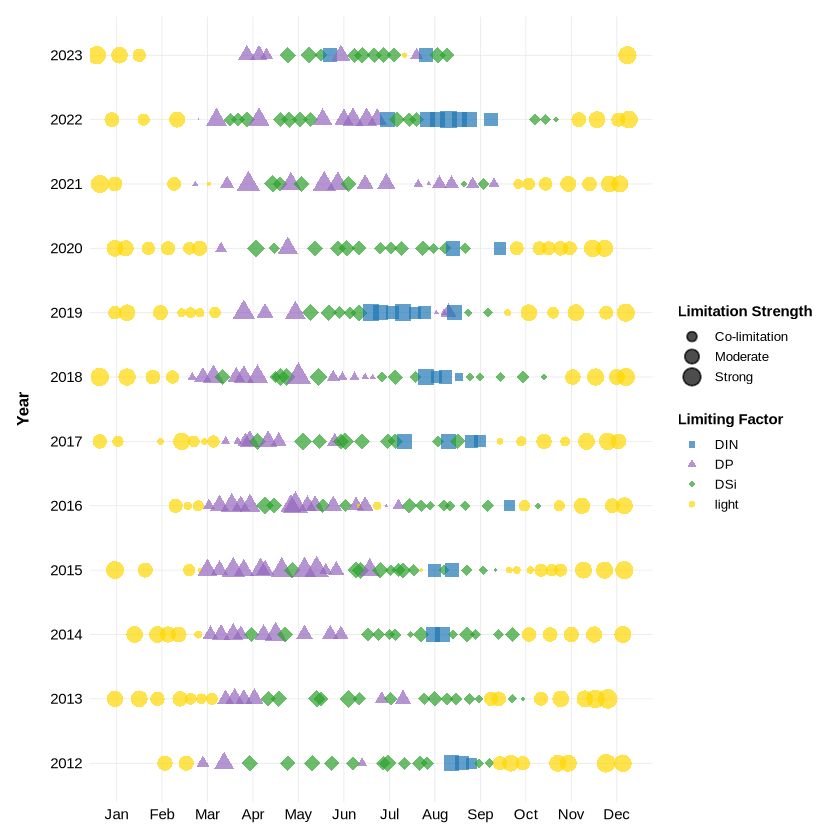

In [15]:
## *Fig 6*: Interannual variation of limitations
### Jetty 40

Nut_Light_limitation_df <- read.csv(paste(PP_cal_dir,"Nut_Light_limitation_Jetty40.csv",sep=""))
Nut_Light_limitation_df$Lim_Nut <- factor(Nut_Light_limitation_df$Lim_Nut, levels=c("DIN","DP","DSi"))

shape_mapping <- c("light"=16, #circle
                   "DIN" = 15, # square
                   "DP" = 17, # triangle
                   "DSi" = 18) # diamond
#  

library(ggplot2)
library(scales)

# Create the plot with manuscript-ready formatting
p_cloern <- ggplot(Nut_Light_limitation_df, aes(x = day_of_year, y = year)) +
  geom_point(
    aes(
      shape = limiting_factor,
      color = limiting_factor,
      size = line_thickness
    ),
    alpha = 0.7,  # Slightly increased alpha for better visibility in print
    stroke = 0.8  # Adds outline to points for better definition
  ) +
  scale_shape_manual(
    name = "Limiting Factor",
    values = shape_mapping,
    guide = guide_legend(override.aes = list(size = 3))
  ) + 
  scale_color_manual(
    name = "Limiting Factor",
    values = c(
      "light" = "#FFD700",  # Brighter gold for print visibility
      "DIN" = "#1F77B4",    # Modified blue
      "DP" = "#9467BD",     # Modified purple
      "DSi" = "#2CA02C"     # Modified green
    ),
    guide = guide_legend(override.aes = list(size = 3))
  ) +
  scale_size_continuous(
    name = "Limitation Strength",
    range = c(0, 5),  # Slightly increased size range
    breaks = c(1, 2.5, 4),
    labels = c("Co-limitation", "Moderate", "Strong")
  ) +
  scale_x_continuous(
    limits = c(1, 365),
    breaks = seq(15, 345, by = 30),  # Center month labels
    labels = month.abb[1:12],        # Use built-in month abbreviations
    expand = c(0.01, 0.01)          # Tighten axis padding
  ) +
  scale_y_continuous(
    breaks = unique(Nut_Light_limitation_df$year),  # Show all years
    expand = c(0.05, 0.05)
  ) +
  labs(
    x = NULL,  # Remove axis title (months are self-explanatory)
    y = "Year"
    # ,
    # title = "Seasonal Nutrient and Light Limitation Patterns",
    # subtitle = "Marsdiep (2012-2023)"
  ) +
  theme_minimal(base_size = 10) +
  theme(
    text = element_text(family = "sans"),  # Use journal-preferred font
    axis.text = element_text(size = 9, color = "black"),
    axis.title.y = element_text(size = 10, face = "bold", margin = margin(r = 10)),
    axis.title.x = element_blank(),
    plot.title = element_text(size = 11, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 10, hjust = 0.5, margin = margin(b = 10)),
    panel.grid.major = element_line(color = "gray90", linewidth = 0.2),
    panel.grid.minor = element_blank(),
    legend.position = "right",
    legend.spacing = unit(5, "pt"),
    legend.title = element_text(face = "bold", size = 9),
    legend.text = element_text(size = 8),
    legend.key.height = unit(12, "pt"),
    plot.margin = margin(10, 10, 10, 10)
  ) +
  guides(
    size = guide_legend(order = 1),
    color = guide_legend(order = 2),
    shape = guide_legend(order = 2)
  )
p_cloern
# Save as high-quality single-column figure
# ggsave(
#   filename = file.path(graph_dir, "FigX_Cloern_Limitations.png"),
#   plot = p_cloern,
#   device = "png",
#   width = 7,       # Standard single-column width (inches)
#   height = 5,        # Adjusted height for better proportions
#   units = "in",
#   dpi = 600,         # Publication quality
#   bg = "white"
# )

# For TIFF format (required by some journals):
#ggsave(filename = file.path(graph_dir, "Fig5_Cloern_Limitations.tiff"),  p_cloern,
#       width = 7, height = 5, units = "in", dpi = 600,
#       compression = "lzw")